# Модель предсказания оттока клиентов компании «ТелеДом»

# Описание проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

# Цель
Обучить модель для прогноза оттока клиентов.

# План задач
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

## Загрузка данных

In [1]:
!pip install missingno -q
!pip install phik -q
!pip install lightgbm==3.3.1 -q
!pip install scikit-learn --upgrade -q
!pip install shap -q
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import missingno as msno
import seaborn as sns
import phik as ph
import warnings
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve
import shap

In [2]:
RANDOM_STATE = 28102024
TEST_SIZE = 0.25

### Информация о договоре, df_contract

In [3]:
df_contract = pd.read_csv('contract_new.csv')

df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Пропуски отсутствуют, столбцам BeginDate и TotalCharges стоит изменить тип данных, названия столбцов можно привести к змеиному регистру.

### Персональные данные клиента, df_personal

In [4]:
df_personal = pd.read_csv('personal_new.csv')

df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Пропуски отсутствуют, типы данных столбцов корректны, названия столбцов можно привести к змеиному регистру, также стоит преобразовать категории стобца SeniorCitizen.

### Информация об интернет-услугах, df_internet

In [5]:
df_internet = pd.read_csv('internet_new.csv')

df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Пропуски отсутствуют, типы данных столбцов корректны, названия столбцов можно привести к змеиному регистру.

### Информация об услугах телефонии, df_phone

In [6]:
df_phone = pd.read_csv('phone_new.csv')

df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Пропуски отсутствуют, типы данных столбцов корректны, названия столбцов можно привести к змеиному регистру.

## Исследовательский анализ и предобработка данных

### Предобработка данных

#### Изменение названий столбцов

##### df_contract

In [7]:
def camel_to_snake(str, sep='_'):
    new_cols = []
    for col in str:
        new_cols.append(re.sub('(?<=[a-zA-Z])([A-Z])',(sep + '\g<1>'),col).lower())
    return new_cols

df_contract.columns = camel_to_snake(df_contract.columns)
df_contract.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


##### df_personal

In [8]:
df_personal.columns = camel_to_snake(df_personal.columns)
df_personal.head()

,customer_i_d,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


##### df_internet

In [9]:
df_internet.columns = camel_to_snake(df_internet.columns)
df_internet.head()

,customer_i_d,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


##### df_phone

In [10]:
df_phone.columns = camel_to_snake(df_phone.columns)
df_phone.head()

,customer_i_d,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


#### Изменение типов данных

##### df_contract

Необходимо изменить тип данных столбцам begin_date и total_charges.

In [11]:
df_contract['begin_date']  = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


В столбце total_charges имеются пропуски, выраженные ' '. На данном этапе просто заполним их маркерным значением -1.

In [12]:
df_contract['total_charges'] = df_contract['total_charges'].apply(lambda x: np.nan if (x==' ') else x)
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'])
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


#### Преобразование столбцов

##### df_contract

Преобразуем таргет в бинарный признак.

In [13]:
df_contract['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [14]:
df_contract['refused'] = df_contract['end_date'].apply(lambda x: 'Yes' if (x!='No') else 'No')

df_contract['refused'].unique()

array(['No', 'Yes'], dtype=object)

##### df_personal

Преобразуем столбец senior_citizen

In [15]:
df_personal['senior_citizen'].unique()

array([0, 1], dtype=int64)

In [16]:
df_personal['senior_citizen'] = df_personal['senior_citizen'].apply(lambda x: 'Yes' if (x==1) else 'No')

#### Обработка неявных дубликатов

##### df_contract

In [17]:
def dupl(df):
    for col in df:
        if df[col].dtype == 'O':
            print(col, df[col].unique())
            
dupl(df_contract)

customer_i_d ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
end_date ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
type ['Month-to

Неявные дубликаты отсутствуют.

##### df_personal

In [18]:
dupl(df_personal)

customer_i_d ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
senior_citizen ['No' 'Yes']
partner ['Yes' 'No']
dependents ['No' 'Yes']


Неявные дубликаты отсутствуют.

##### df_internet

In [19]:
dupl(df_internet)

customer_i_d ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
internet_service ['DSL' 'Fiber optic']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_t_v ['No' 'Yes']
streaming_movies ['No' 'Yes']


##### df_phone

In [20]:
dupl(df_phone)

customer_i_d ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
multiple_lines ['No' 'Yes']


#### Обработка явных дубликатов

##### df_contract

In [21]:
df_contract.duplicated().sum()

0

In [22]:
df_contract['customer_i_d'].duplicated().sum()

0

Явные дубликаты отсутствуют.

##### df_personal

In [23]:
df_personal.duplicated().sum()

0

In [24]:
df_contract['customer_i_d'].duplicated().sum()

0

Явные дубликаты отсутствуют.

##### df_internet

In [25]:
df_internet.duplicated().sum()

0

In [26]:
df_internet['customer_i_d'].duplicated().sum()

0

Явные дубликаты отсутствуют.

##### df_phone

In [27]:
df_phone.duplicated().sum()

0

In [28]:
df_phone['customer_i_d'].duplicated().sum()

0

Явные дубликаты отсутствуют.

### Исследовательский анализ данных

#### df_contract

##### begin_date

Пользователи заключали договора с 2013-10-01 00:00:00 по 2020-02-01 00:00:00


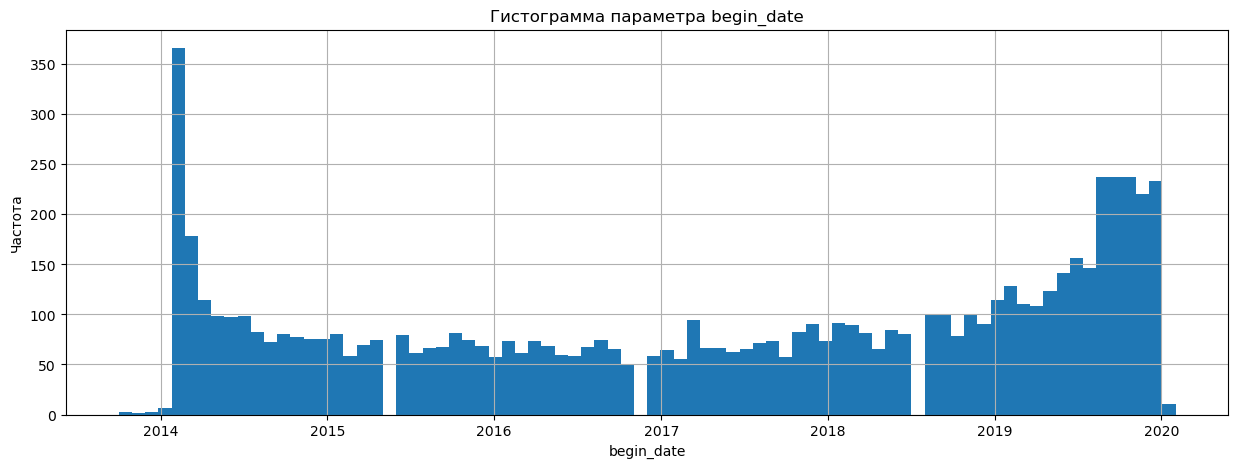

In [29]:
def hist(ser, bins):
    ser.hist(figsize=(15,5), grid=True, bins = bins)
    plt.title("Гистограмма параметра "+ser.name)
    plt.xlabel(ser.name)
    plt.ylabel("Частота")

hist(df_contract['begin_date'], 80)

print('Пользователи заключали договора с', min(df_contract['begin_date']), 'по', max(df_contract['begin_date']))

Стоит отметить параболический характер зависимости частоты от времени на данном временном промежутке. Сам по себе признак полезной информации не несет, в дальнейшем есть смысл его преобразовать. 

##### refused

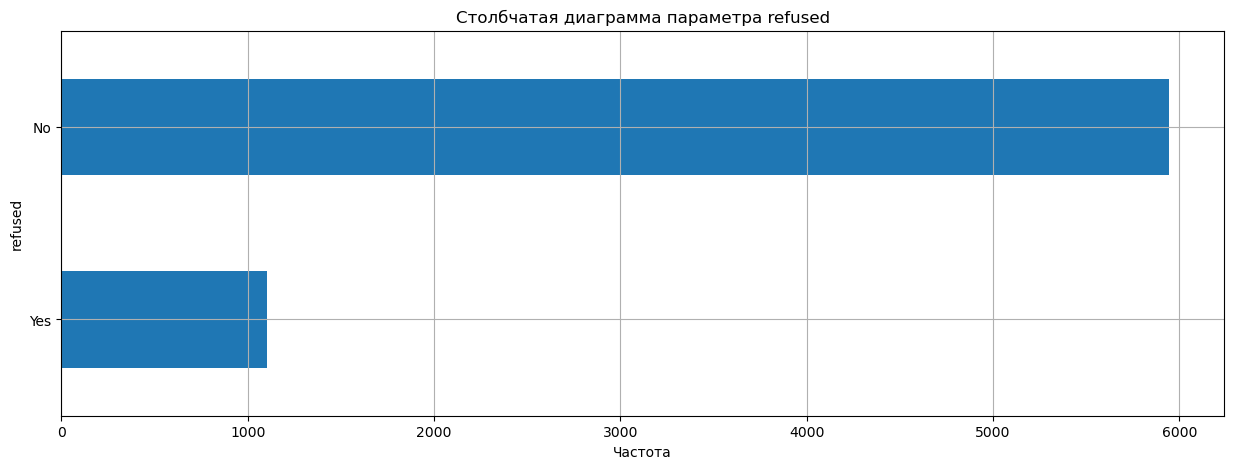

In [30]:
def barh(ser):
    ser.value_counts(ascending=True).plot.barh(figsize=(15,5), grid=True)
    plt.title("Столбчатая диаграмма параметра "+ser.name)
    plt.xlabel("Частота")
    plt.ylabel(ser.name)
    
barh(df_contract['refused']) 

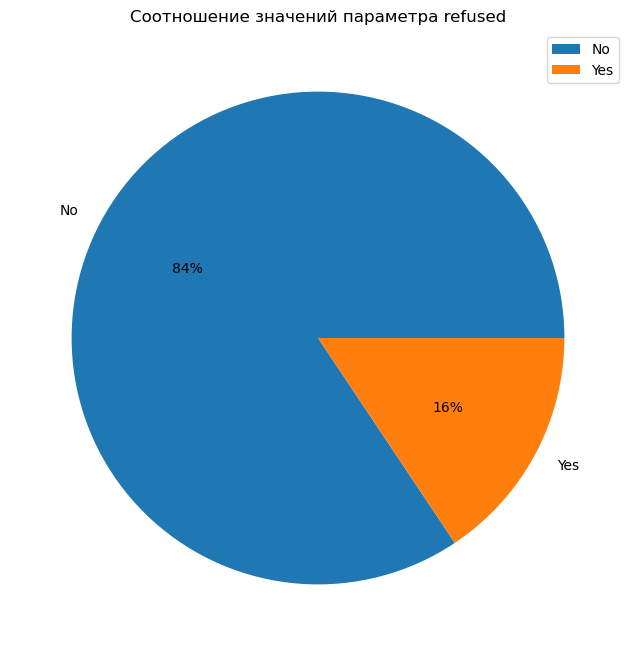

In [31]:
def pie(df, ser):
    df.groupby([ser]).count().plot(kind='pie', figsize=(15,8), y='customer_i_d', title="Cоотношение значений параметра"+' '+ser,
                                   autopct='%1.0f%%', ylabel='')
    
pie(df_contract, 'refused')

Наблюдается логичный перевес категории No, соответственно имеем дисбаланс классов.

##### type

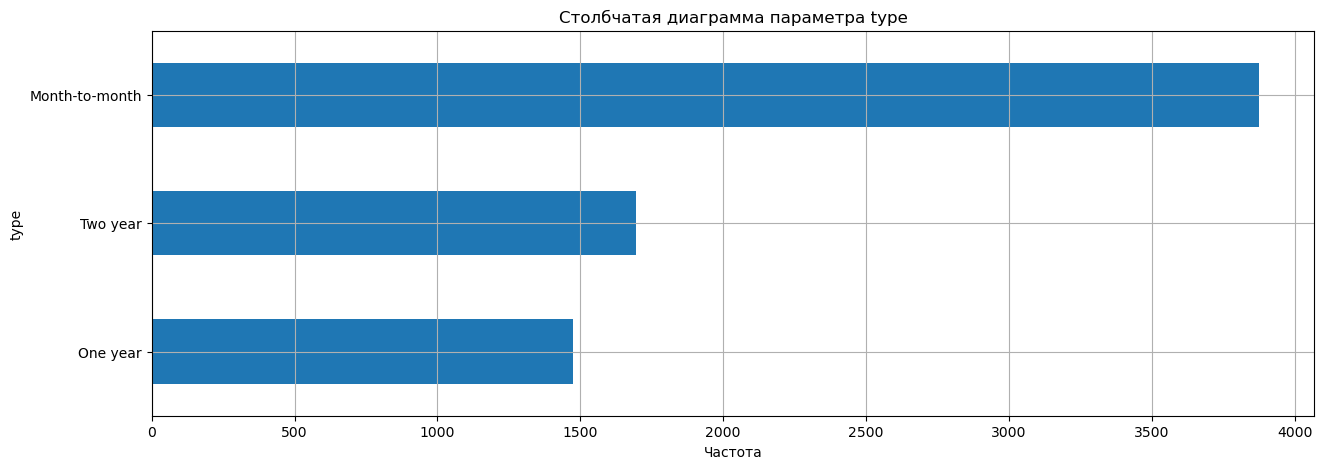

In [32]:
barh(df_contract['type']) 

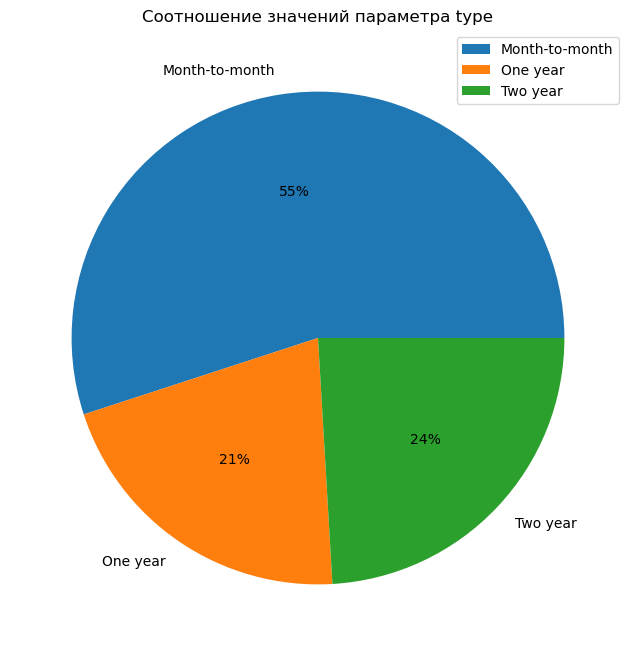

In [33]:
pie(df_contract, 'type')

##### paperless_billing

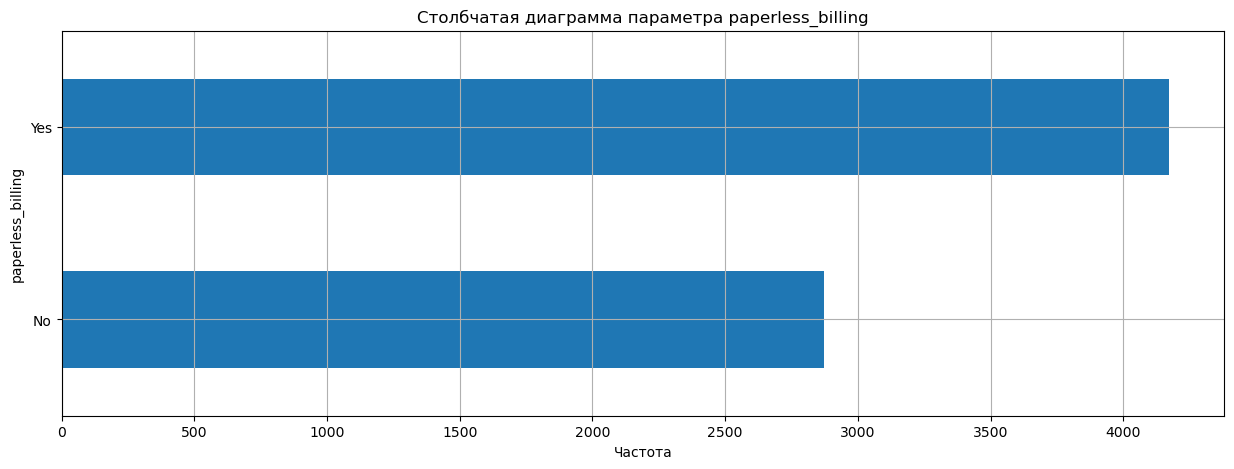

In [34]:
barh(df_contract['paperless_billing']) 

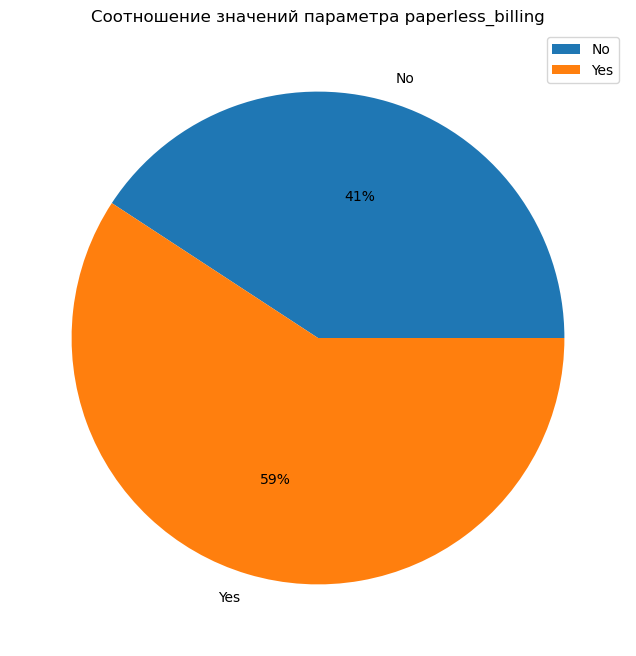

In [35]:
pie(df_contract, 'paperless_billing')

##### payment_method	

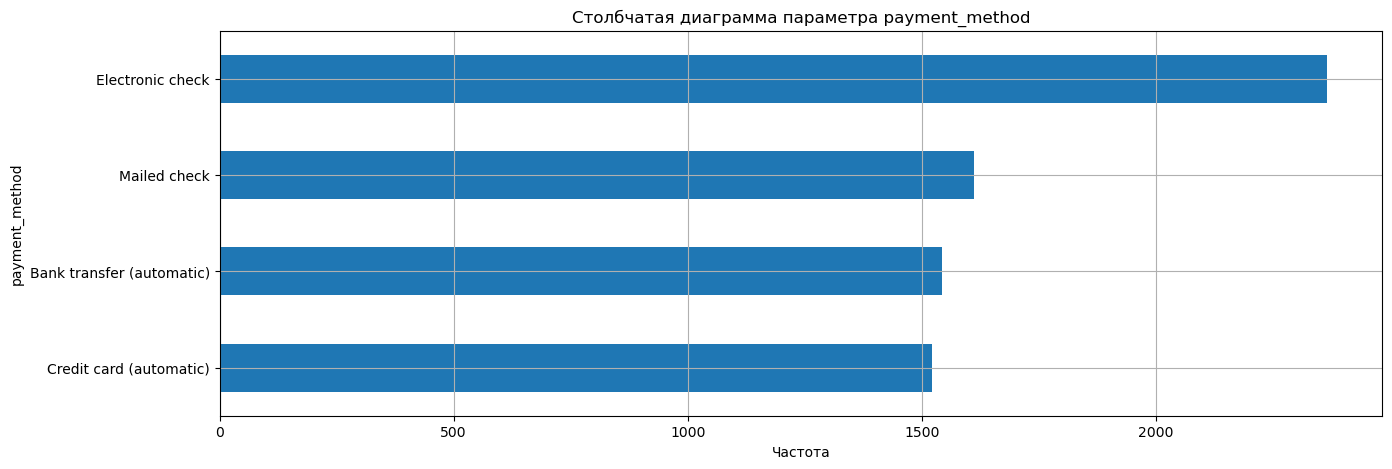

In [36]:
barh(df_contract['payment_method']) 

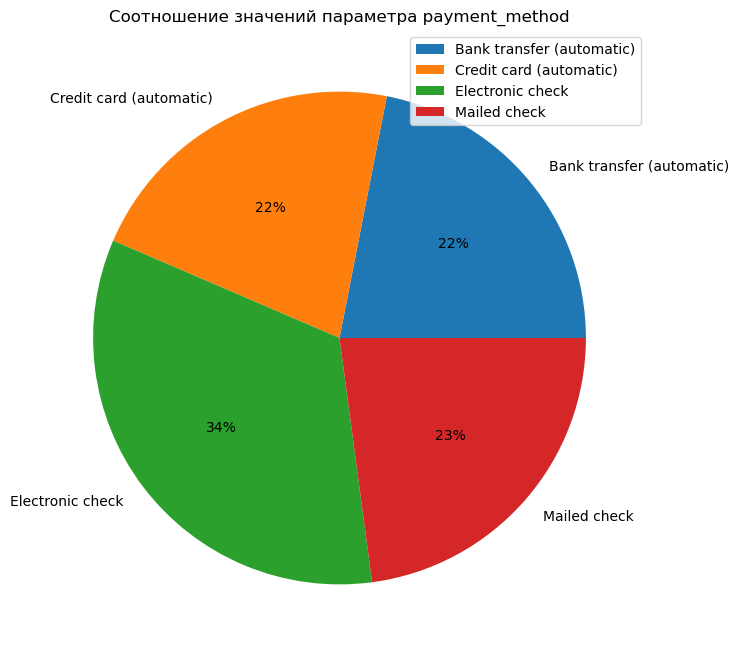

In [37]:
pie(df_contract, 'payment_method')

##### monthly_charges

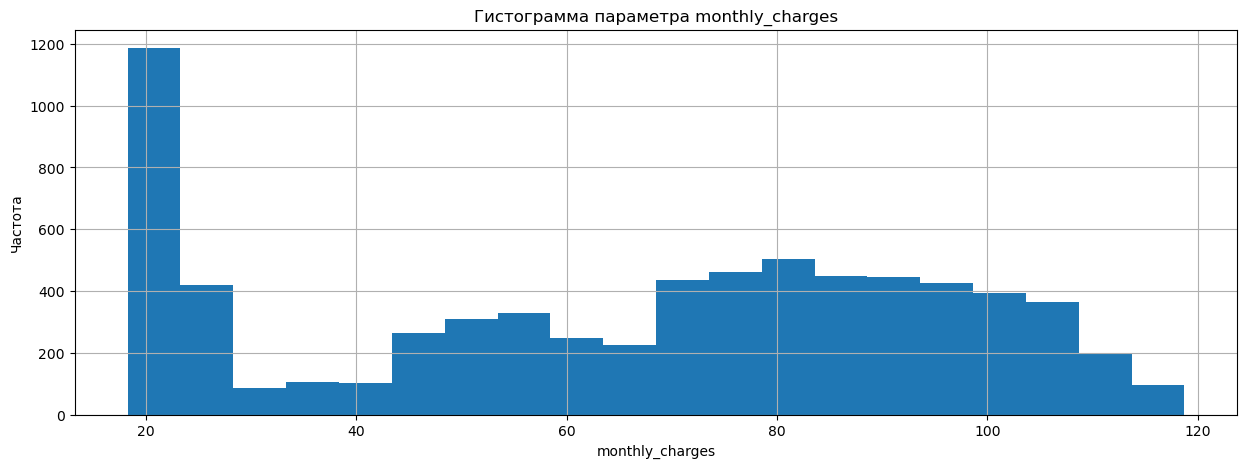

In [38]:
hist(df_contract['monthly_charges'], 20)

Заметен пик в районе 20.

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


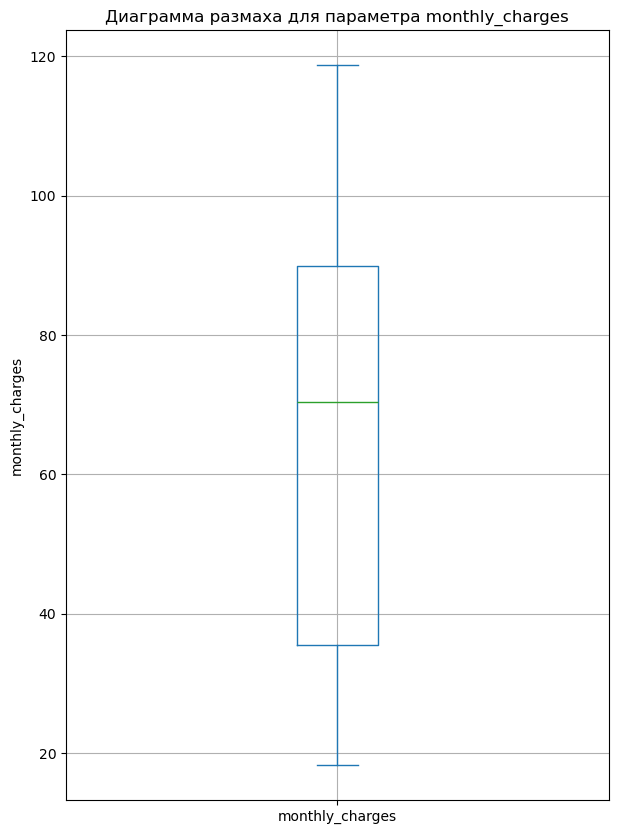

In [39]:
def box(ser):
    plt.title("Диаграмма размаха для параметра "+ser.name)
    plt.ylabel(ser.name)
    ser.plot(kind='box', figsize=(7, 10), grid=True)
    print(ser.describe())
    
box(df_contract['monthly_charges'])

Чаще всего месячные расходы составляют от 35.5 до 89.85.

##### total_charges

В данном параметре имеются пропуски, их необходимо обработать.

In [40]:
df_contract[df_contract.isna().any(axis=1)]

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,refused
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,No


Скорее всего пропуски образовались вследствии того, что данные пользователи подписали договор 2020-02-01, что является крайней датой рассматриваемого периода. Проверим это.

In [41]:
df_contract.query('begin_date == "2020-02-01"')

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,refused
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,No


Действительно, пропуски есть только у пользователей с датой заключения договора 2020-02-01. Для заполнения пропусков можно умножить параметр monthly_charges на количество месяцев действия договора, которое можно получить из параметра type.

In [42]:
df_contract.loc[(df_contract['begin_date'] == "2020-02-01") & (df_contract['type'] == "Two year"), 'total_charges'] = \
df_contract[(df_contract['begin_date'] == "2020-02-01") & (df_contract['type'] == "Two year")]['monthly_charges'] * 24

df_contract.loc[(df_contract['begin_date'] == "2020-02-01") & (df_contract['type'] == "One year"), 'total_charges'] = \
df_contract[(df_contract['begin_date'] == "2020-02-01") & (df_contract['type'] == "One year")]['monthly_charges'] * 12

In [43]:
df_contract.query('begin_date == "2020-02-01"')

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,refused
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,1261.2,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,486.0,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,1940.4,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,618.0,No
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,1345.2,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,476.4,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,608.4,No
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,480.0,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,236.4,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,1760.4,No


Пропуски успешно устранены!

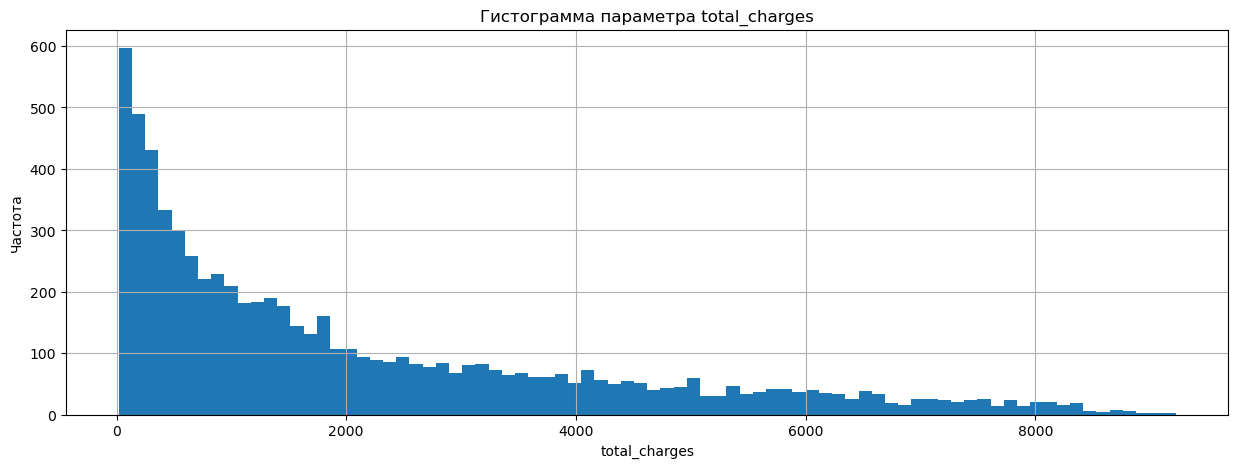

In [44]:
hist(df_contract['total_charges'], 80)

count    7043.000000
mean     2116.831840
std      2111.690571
min        19.050000
25%       440.205000
50%      1344.510000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64


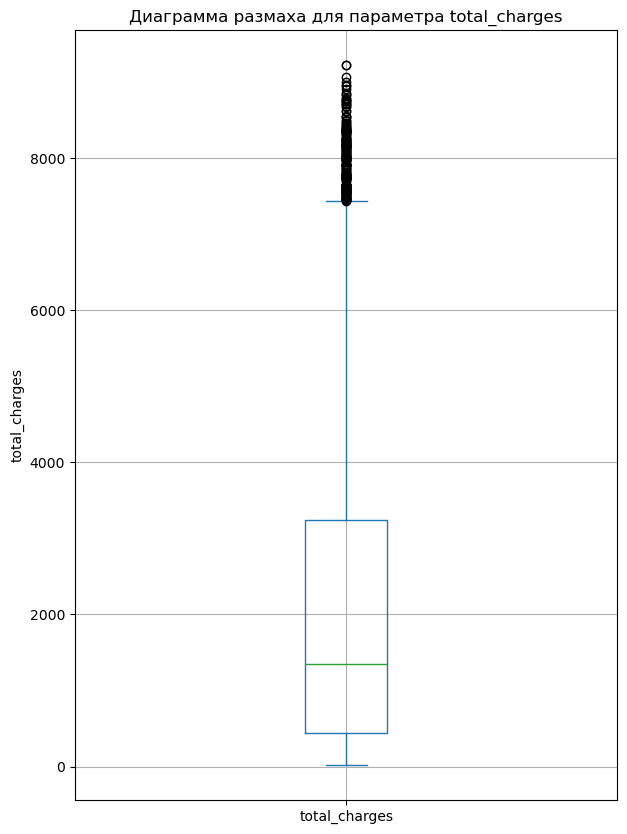

In [45]:
box(df_contract['total_charges'])

Чаще всего суммарные расходы составляют от 440.205 до 3236.69.

#### df_personal

##### gender

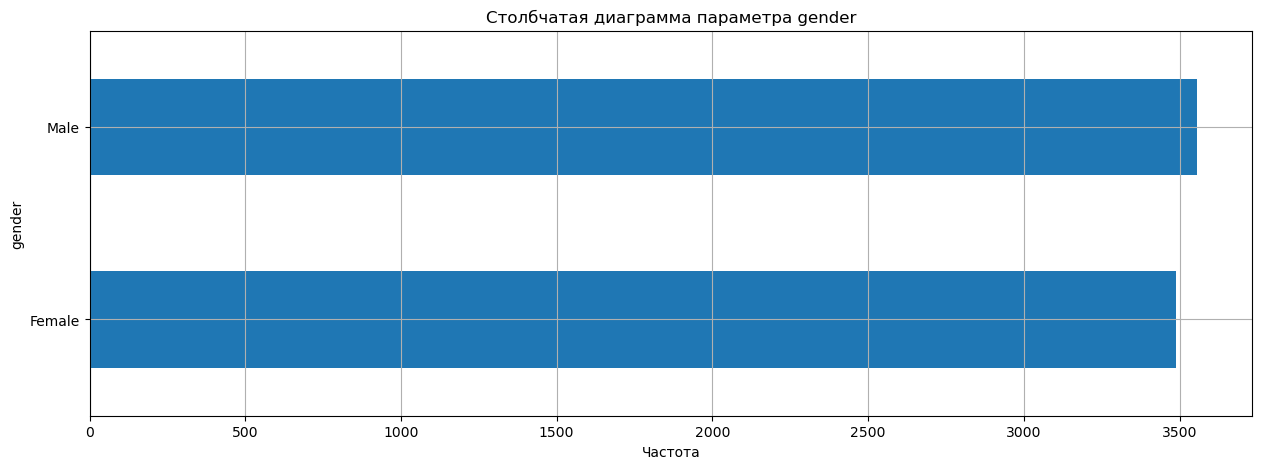

In [46]:
barh(df_personal['gender']) 

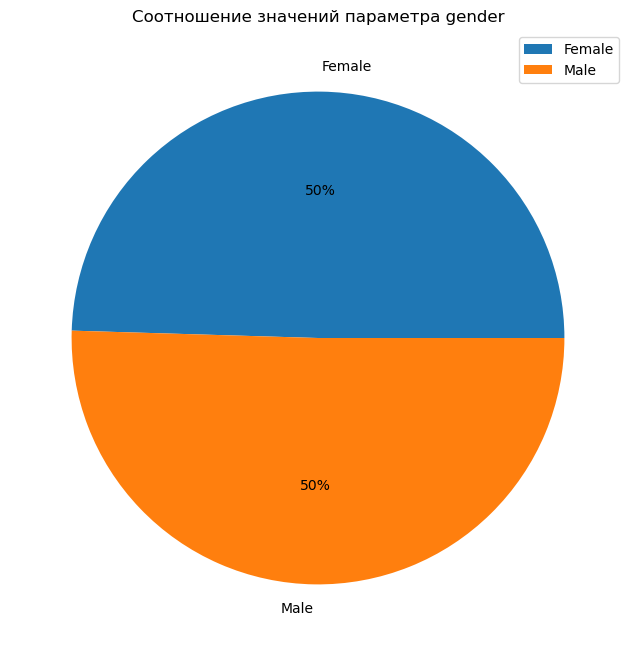

In [47]:
pie(df_personal, 'gender')

##### senior_citizen

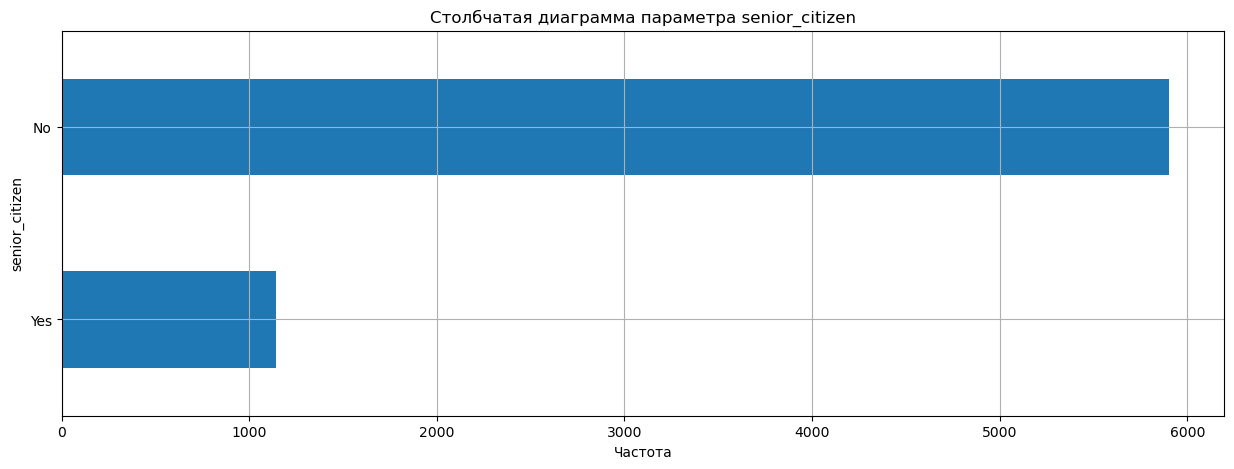

In [48]:
barh(df_personal['senior_citizen']) 

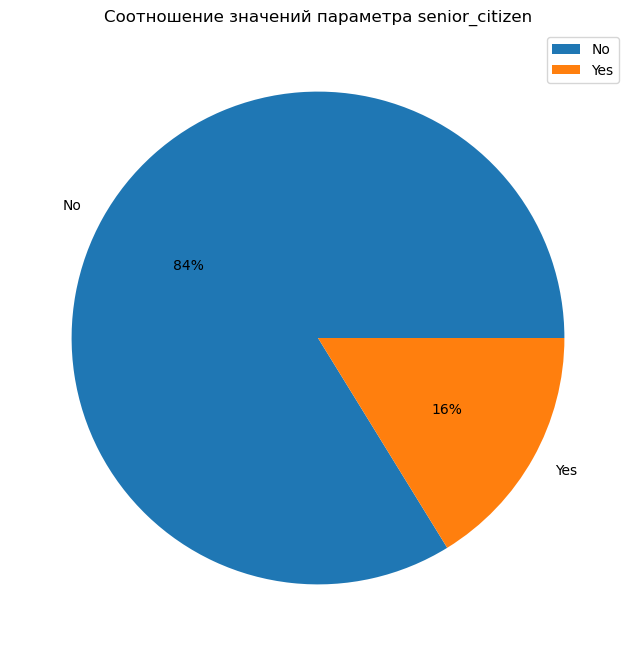

In [49]:
pie(df_personal, 'senior_citizen')

##### partner

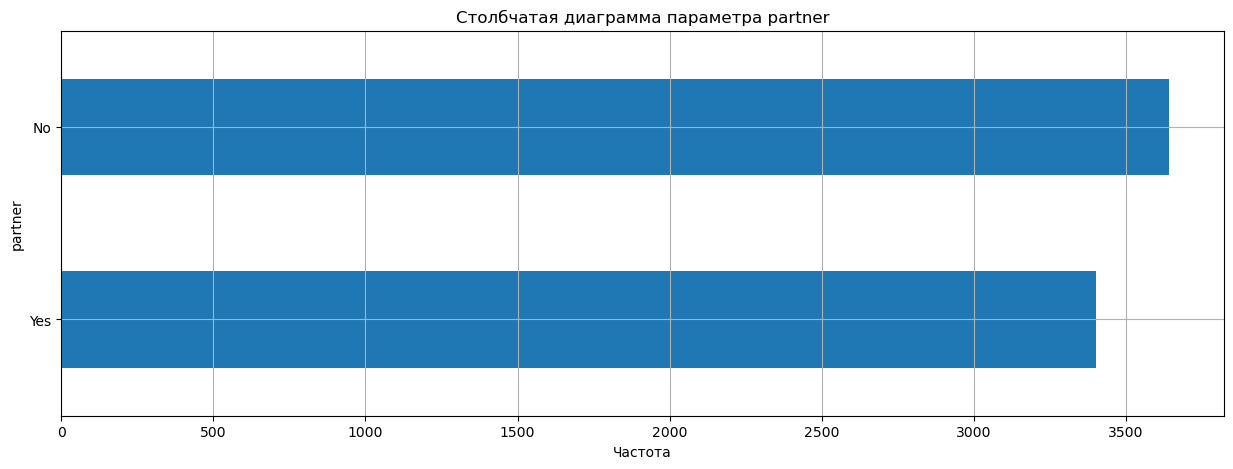

In [50]:
barh(df_personal['partner']) 

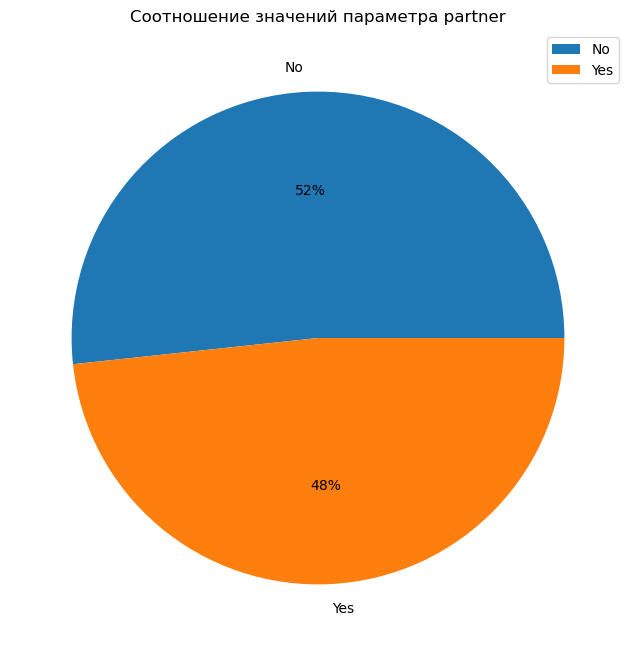

In [51]:
pie(df_personal, 'partner')

##### dependents

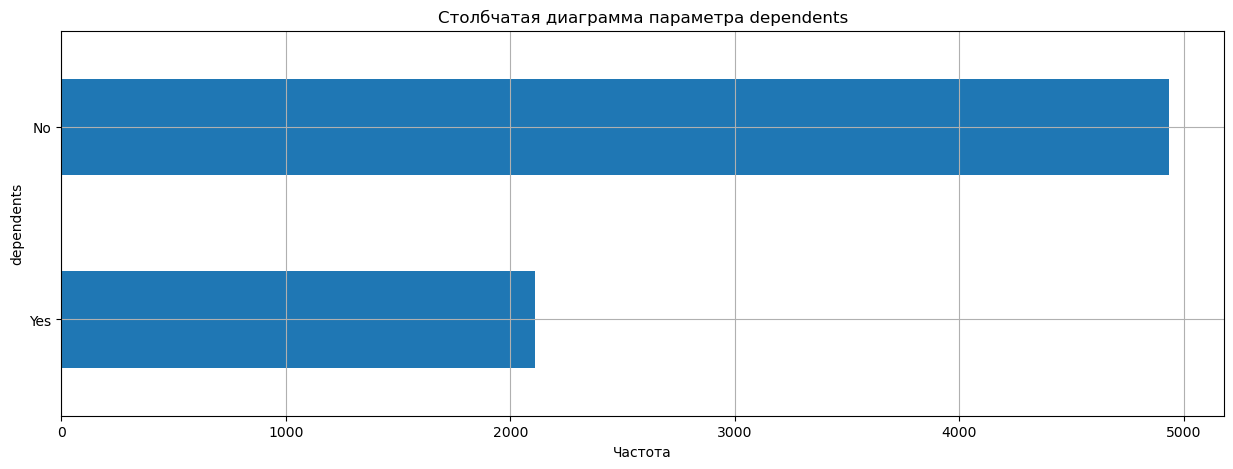

In [52]:
barh(df_personal['dependents']) 

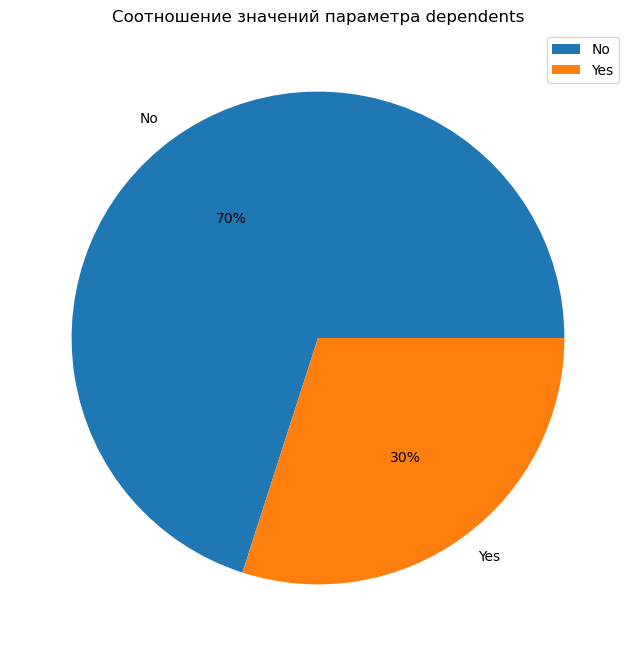

In [53]:
pie(df_personal, 'dependents')

#### df_internet

##### internet_service

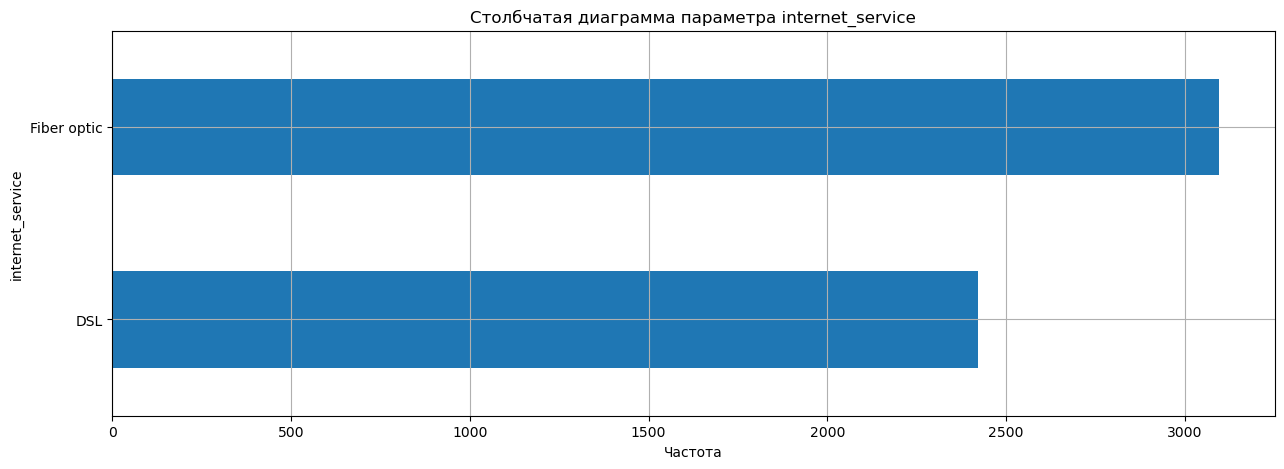

In [54]:
barh(df_internet['internet_service']) 

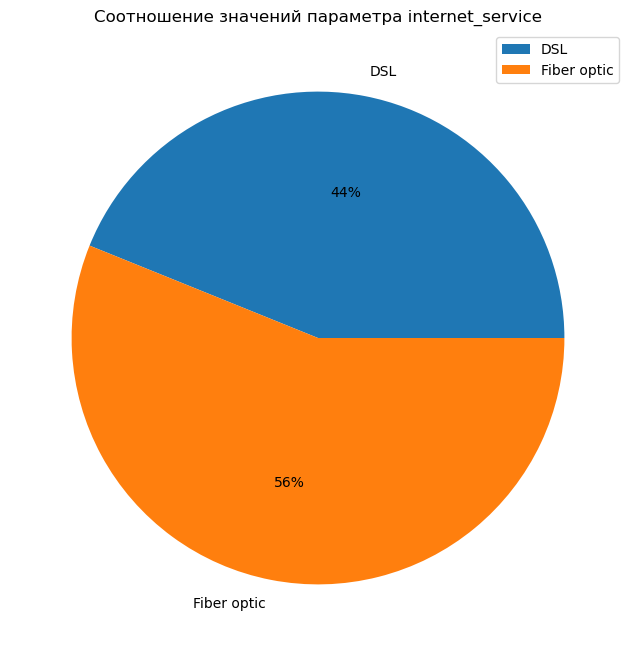

In [55]:
pie(df_internet, 'internet_service')

##### online_security

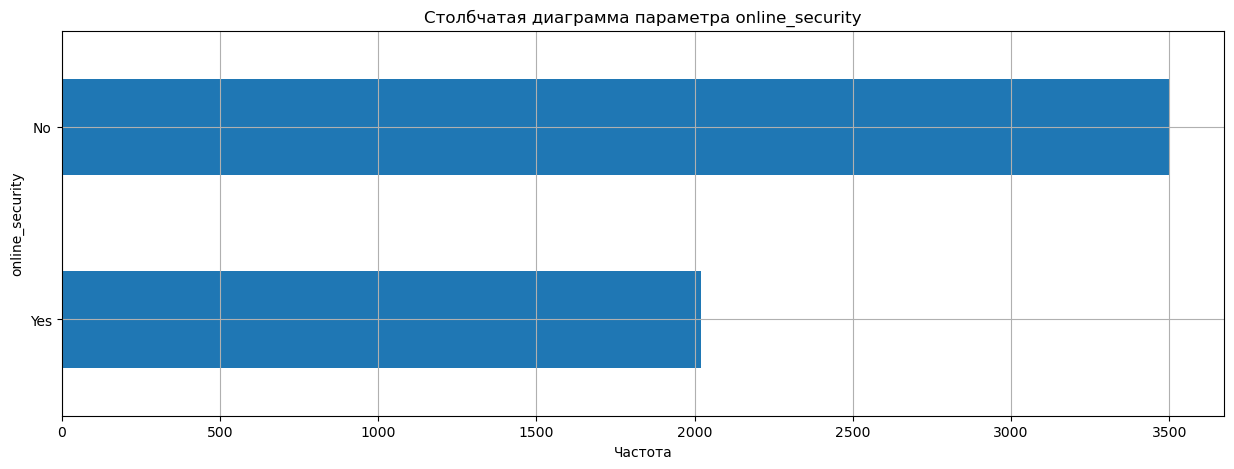

In [56]:
barh(df_internet['online_security']) 

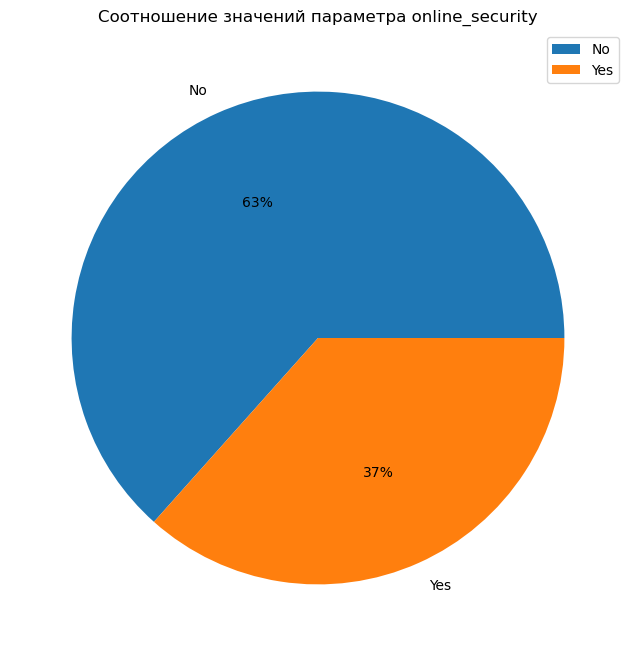

In [57]:
pie(df_internet, 'online_security')

##### online_backup

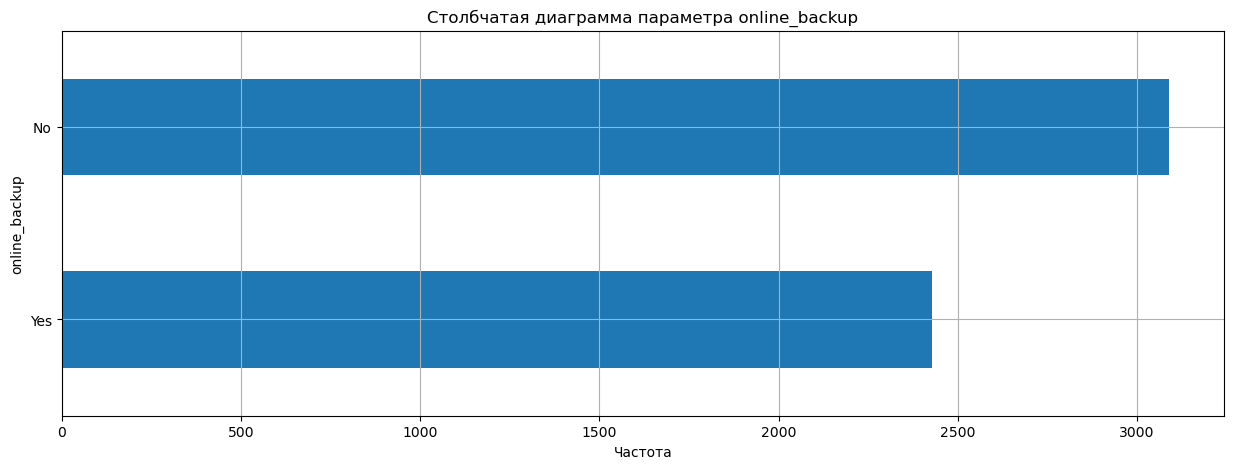

In [58]:
barh(df_internet['online_backup']) 

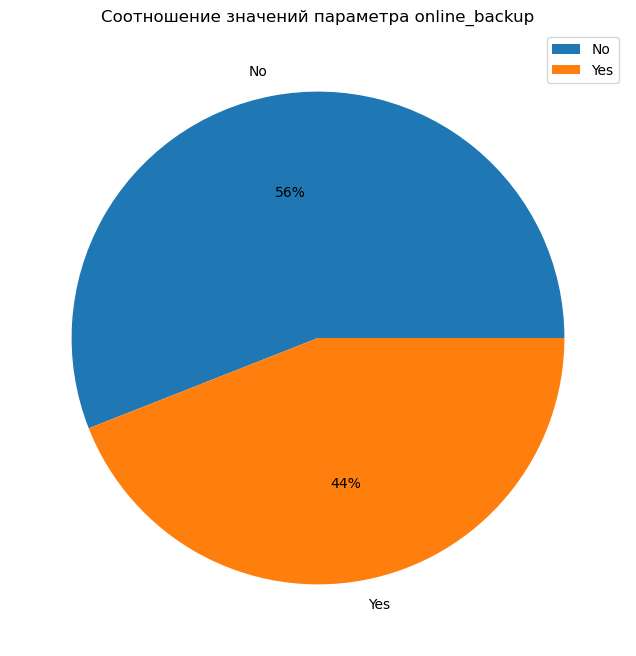

In [59]:
pie(df_internet, 'online_backup')

##### device_protection	

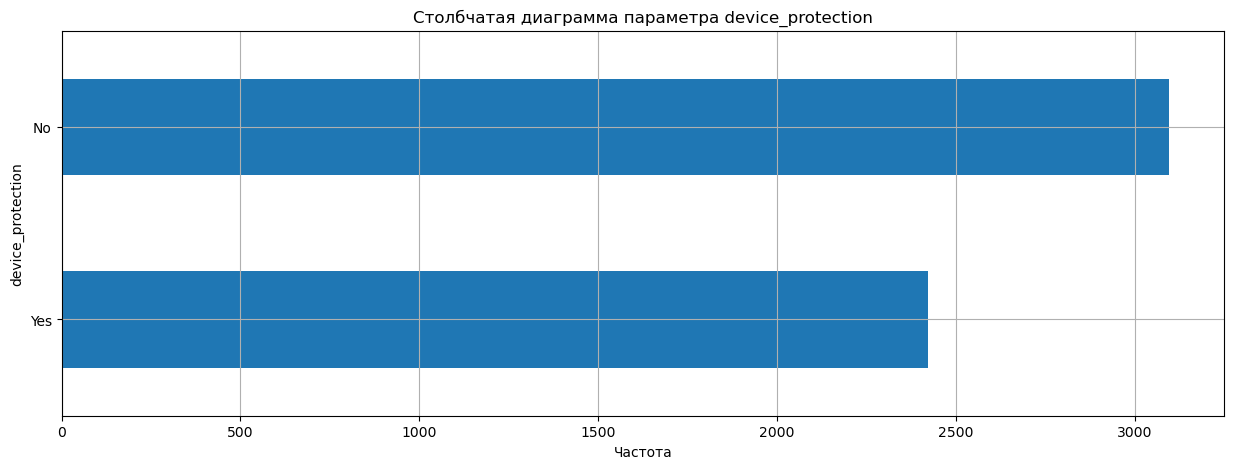

In [60]:
barh(df_internet['device_protection']) 

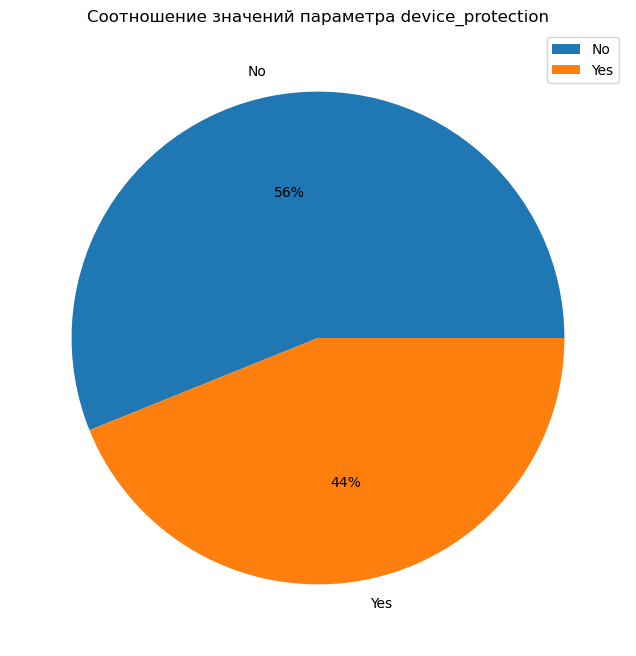

In [61]:
pie(df_internet, 'device_protection')

##### tech_support

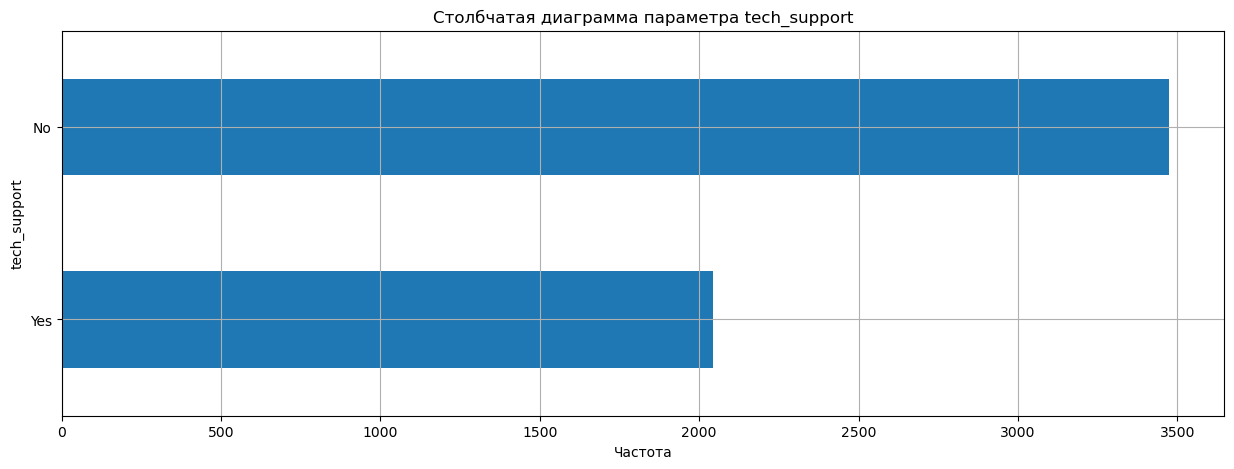

In [62]:
barh(df_internet['tech_support']) 

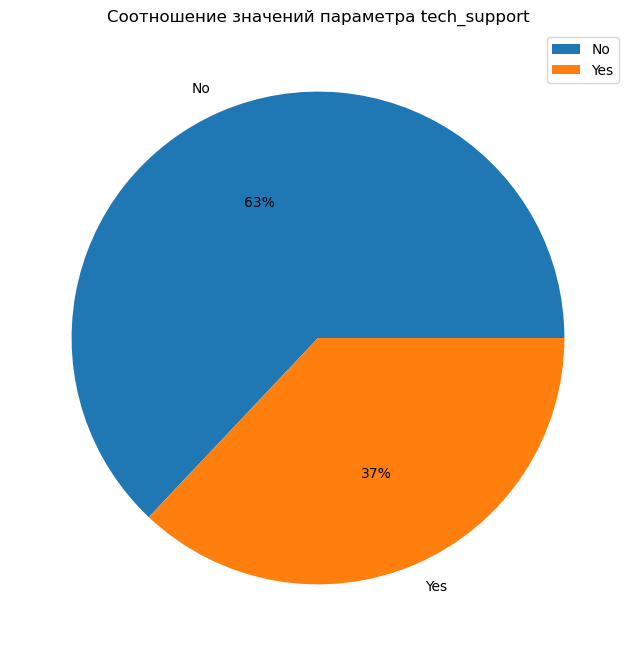

In [63]:
pie(df_internet, 'tech_support')

##### streaming_t_v

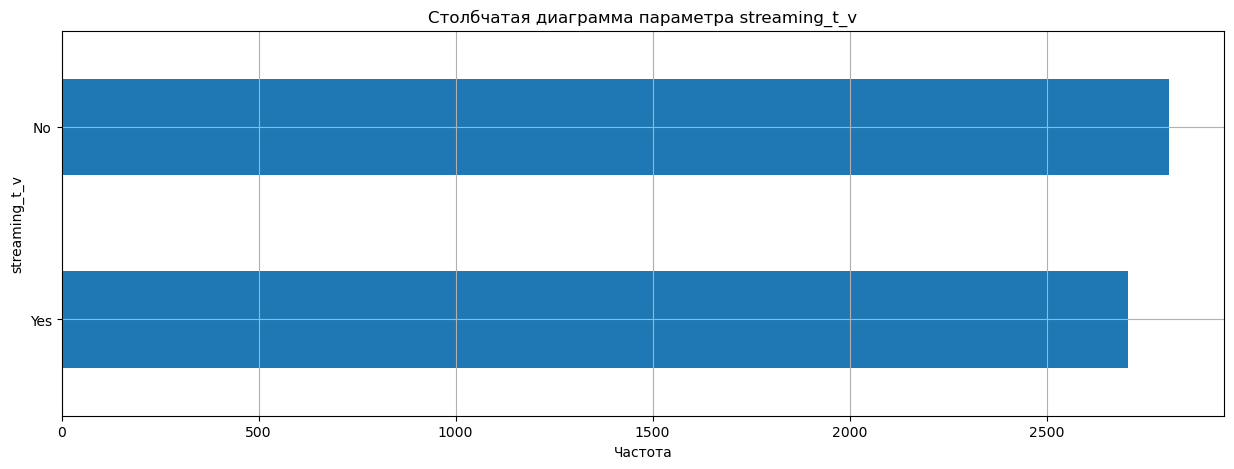

In [64]:
barh(df_internet['streaming_t_v']) 

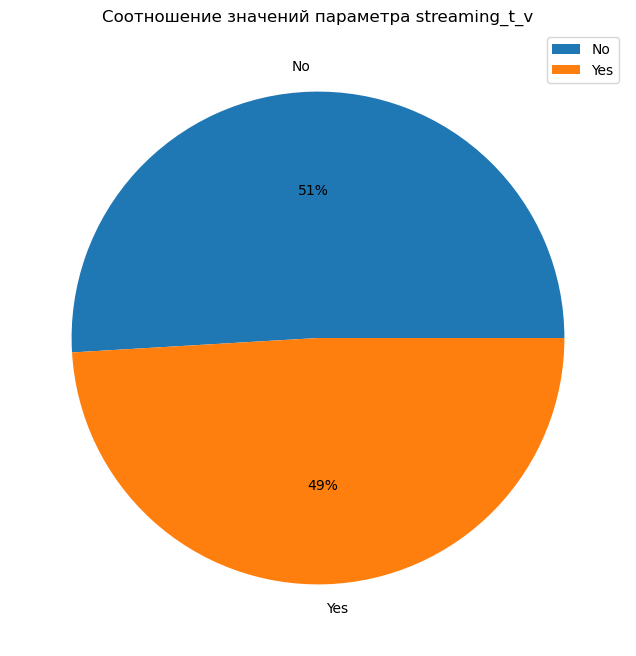

In [65]:
pie(df_internet, 'streaming_t_v')

##### streaming_movies

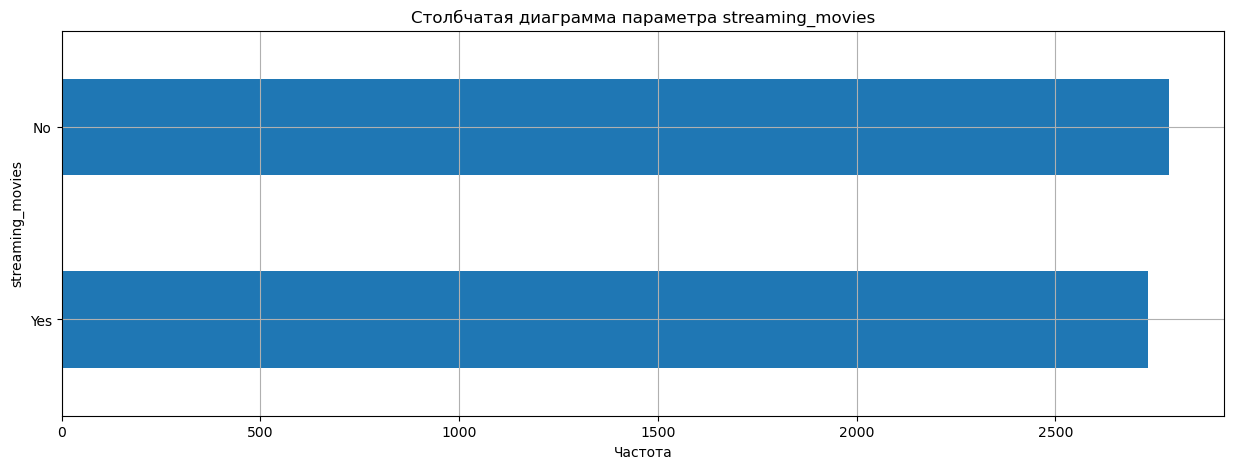

In [66]:
barh(df_internet['streaming_movies']) 

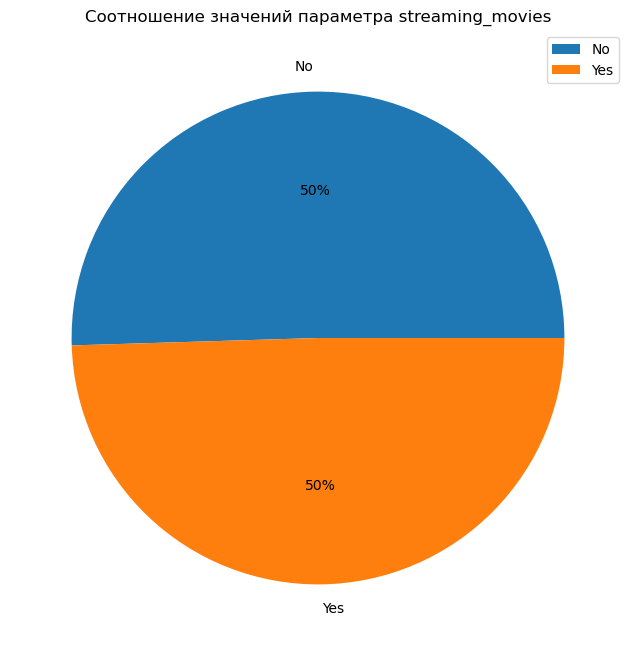

In [67]:
pie(df_internet, 'streaming_movies')

#### df_phone

##### multiple_lines

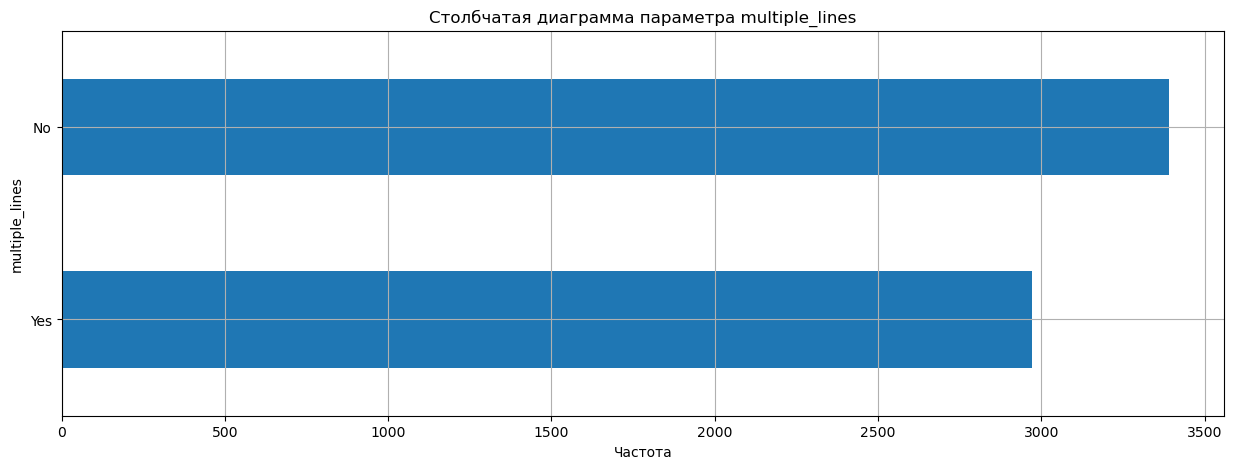

In [68]:
barh(df_phone['multiple_lines']) 

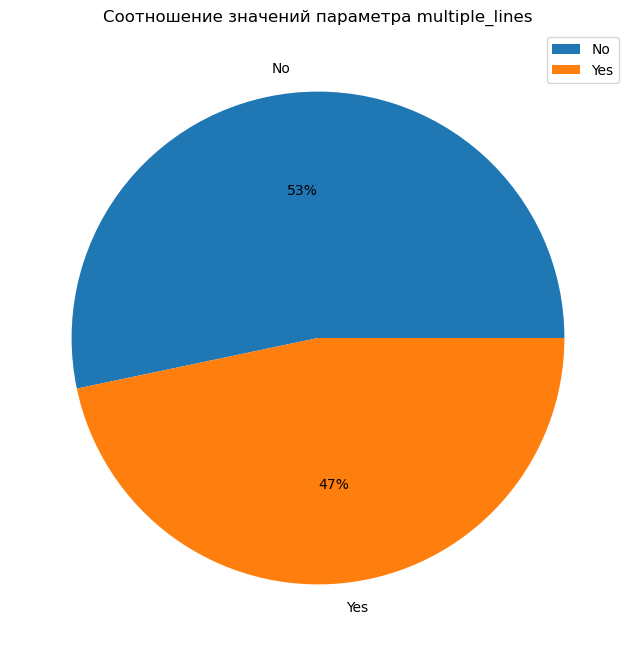

In [69]:
pie(df_phone, 'multiple_lines')

## Объединение данных

In [70]:
df = df_personal.merge(df_contract, on='customer_i_d', how='left')
df = df.merge(df_phone, on='customer_i_d', how='left')
df = df.merge(df_internet, on='customer_i_d', how='left')
df.head()

,customer_i_d,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,total_charges,refused,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,31.04,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,No,No,No,2017-04-01,No,One year,No,Mailed check,...,2071.84,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,No,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,...,226.17,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,1960.60,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,No,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,...,353.50,No,No,Fiber optic,No,No,No,No,No,No


Проверим полученный датафрейм на пропуски.

In [71]:
df[df.isna().any(axis=1)]['customer_i_d'].count()

2208

Визуализируем их.

<Axes: >

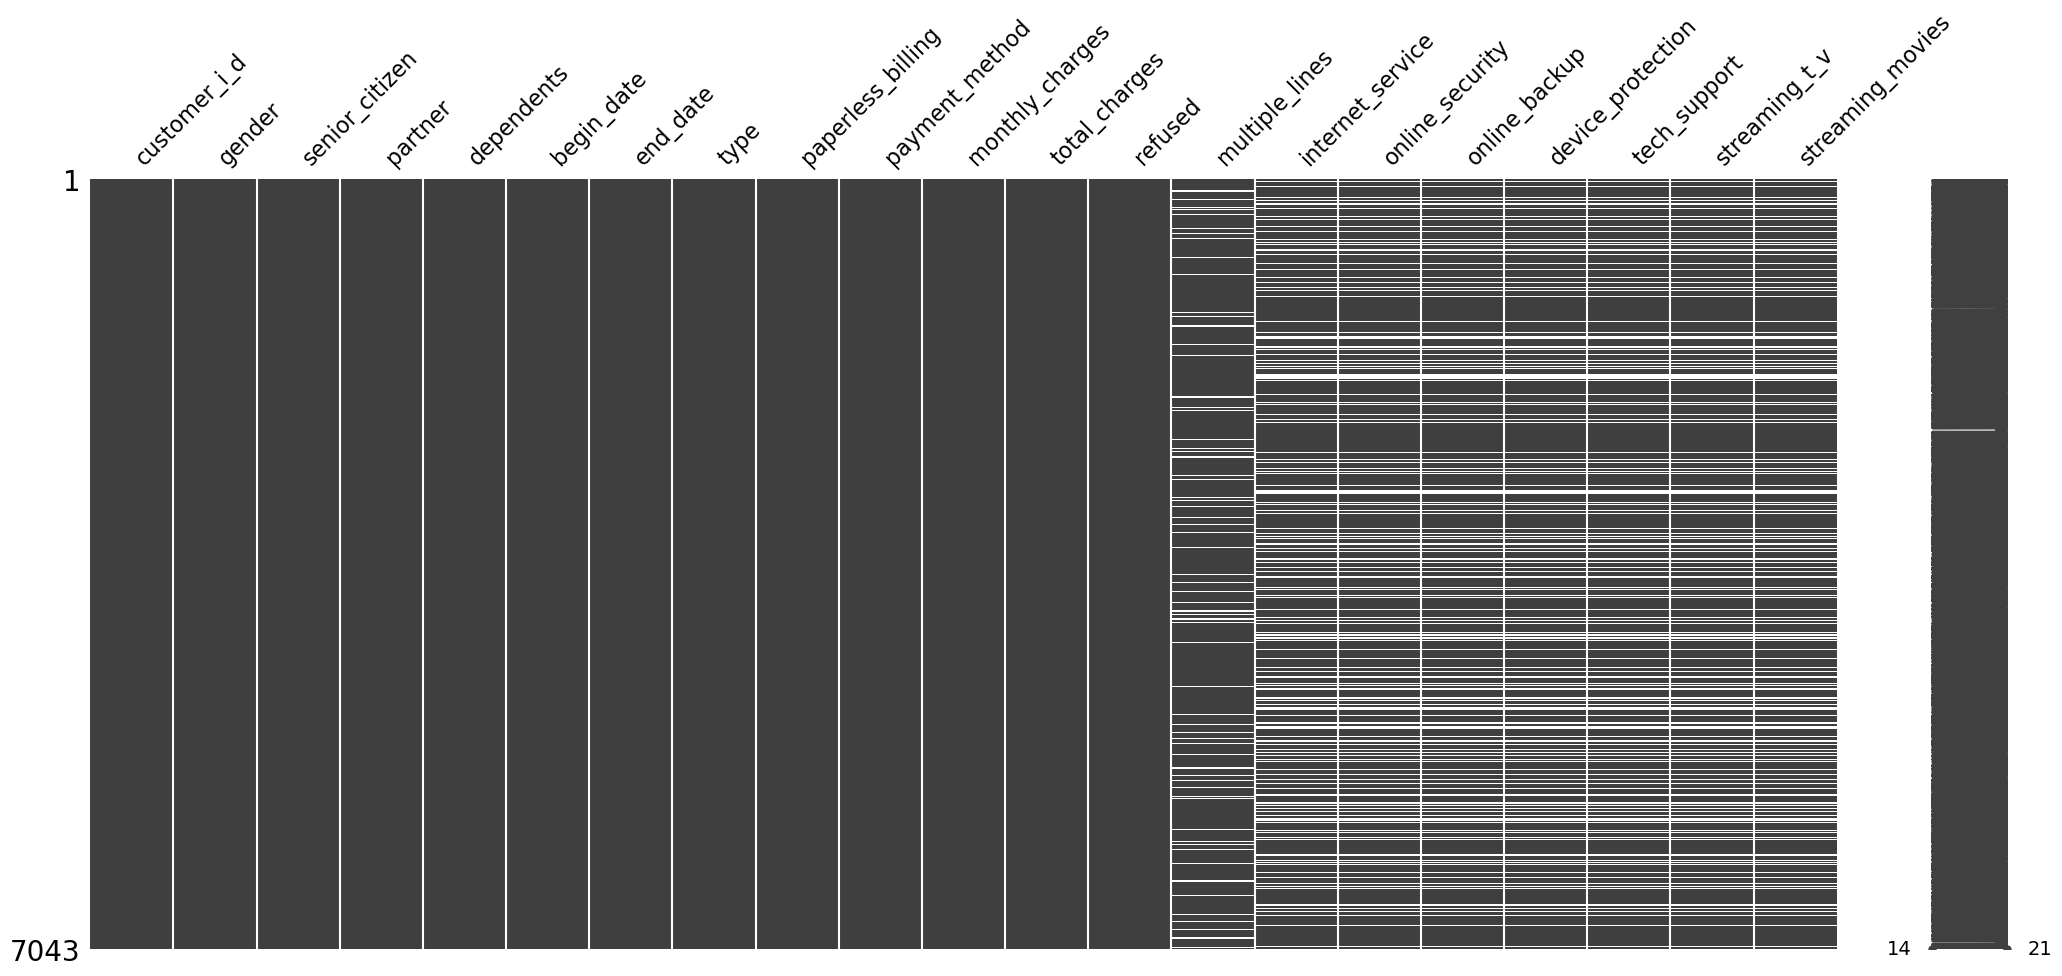

In [72]:
msno.matrix(df)

In [73]:
df[df.isna().any(axis=1)].head(5)

,customer_i_d,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,total_charges,refused,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,31.04,No,NaN,DSL,No,Yes,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,1960.60,No,NaN,DSL,Yes,No,Yes,Yes,No,No
7,6713-OKOMC,Female,No,No,No,2019-04-01,No,Month-to-month,No,Mailed check,...,300.48,No,NaN,DSL,Yes,No,No,No,No,No
11,7469-LKBCI,Male,No,No,No,2018-10-01,No,Two year,No,Credit card (automatic),...,312.30,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,8191-XWSZG,Female,No,No,No,2015-10-01,No,One year,No,Mailed check,...,1106.01,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видно, что пропуски есть либо в параметре multiple_lines, либо в параметрах, связанных с интернетом, скорее всего данные пользователи подключали что-то одно - либо интернет, либо телефонную связь.

In [74]:
df[(df['multiple_lines'].isna() == True) & (df['internet_service'].isna() == True)]

,customer_i_d,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,total_charges,refused,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies


Исходя из того, что нет пользователей с пропусками и в multiple_lines, и в интернет параметрах, предположение подтверждается. Для данных столбцов стоит создать новое значение - Dont use, которым и заполним пропуски, оно будет означать то, что пользователь не подключал данный вид услуг.

In [75]:
df = df.fillna('Dont use')
df[df.isna().any(axis=1)]['customer_i_d'].count()

0

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Созданние новых признаков

#### duration 

Создадим новый признак - длительность пользования услугами. Для пользователей, которые пользуются услугами на момент 01.02.2020 (значение No в end_date) конечной точкой длительности будет эта дата.

In [76]:
df['end_date_v2'] = df['end_date'].apply(lambda x: "2020-02-01" if (x=='No') else x)
df['end_date_v2']  = pd.to_datetime(df['end_date_v2'], format='%Y-%m-%d')

df['duration'] = (df['end_date_v2'] - df['begin_date'])
df['duration'] = pd.to_numeric(df['duration'].dt.days, downcast='integer')

Столбцы begin_date, end_date, end_date_v2 можно удалить.

In [77]:
df = df.drop(['begin_date', 'end_date', 'end_date_v2'], axis=1)
df.head()

,customer_i_d,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,refused,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,duration
0,7590-VHVEG,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,No,Dont use,DSL,No,Yes,No,No,No,No,31
1,5575-GNVDE,Male,No,No,No,One year,No,Mailed check,56.95,2071.84,No,No,DSL,Yes,No,Yes,No,No,No,1036
2,3668-QPYBK,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,DSL,Yes,Yes,No,No,No,No,123
3,7795-CFOCW,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,No,Dont use,DSL,Yes,No,Yes,Yes,No,No,1371
4,9237-HQITU,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,Fiber optic,No,No,No,No,No,No,153


Оценим распределение параметра.

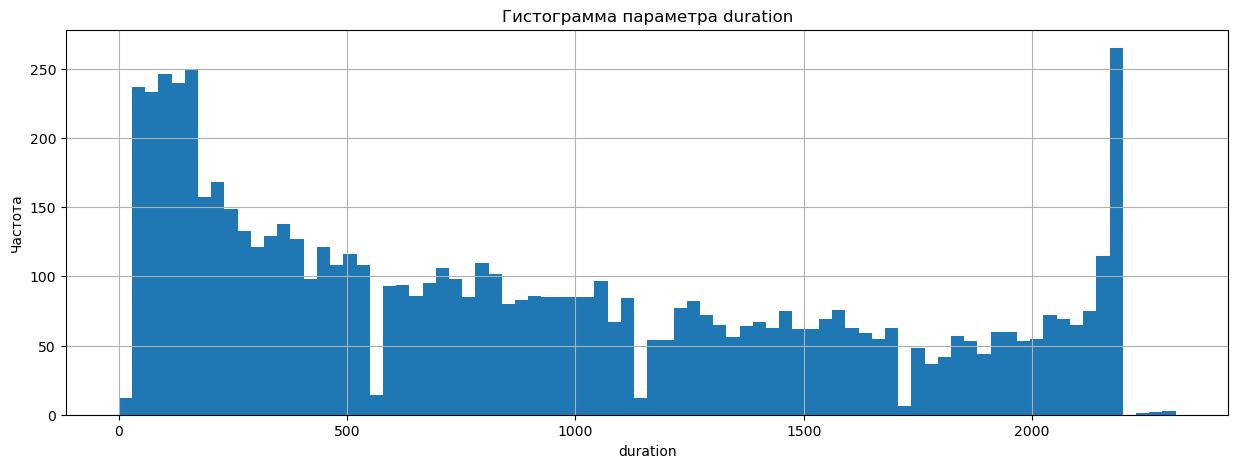

In [78]:
hist(df['duration'], 80)

Распределение соответствует распределению параметра begin_date.

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration, dtype: float64


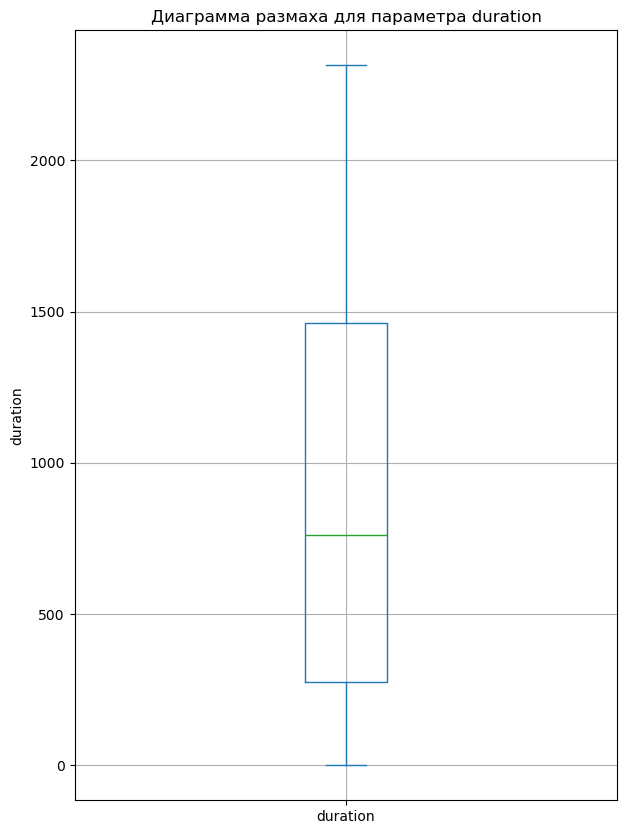

In [79]:
box(df['duration'])

#### number_of_services

Создадим еще один столбец - количество подключенных услуг. Получим его через столбцы: multiple_lines, internet_service, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies

In [80]:
df_new = df.copy()
col_new = ['internet_service', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v',
'streaming_movies', 'online_security']
for col in col_new:
    df_new[col] = df_new[col].apply(lambda x: 1 if ((x=='Yes') or (x=='DSL') or (x=='Fiber optic')) else 0)

df_new['multiple_lines' ] = df_new['multiple_lines' ].apply(lambda x: 0 if (x=='Dont use') else 1)
    
df['number_of_services'] = (df_new['multiple_lines'] + df_new['internet_service'] + df_new['online_backup'] + 
                               df_new['device_protection'] + df_new['tech_support'] + df_new['streaming_t_v'] + 
                               df_new['streaming_movies'] + df_new['online_security'])

df.head()

,customer_i_d,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,...,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,duration,number_of_services
0,7590-VHVEG,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,...,Dont use,DSL,No,Yes,No,No,No,No,31,2
1,5575-GNVDE,Male,No,No,No,One year,No,Mailed check,56.95,2071.84,...,No,DSL,Yes,No,Yes,No,No,No,1036,4
2,3668-QPYBK,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,...,No,DSL,Yes,Yes,No,No,No,No,123,4
3,7795-CFOCW,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,...,Dont use,DSL,Yes,No,Yes,Yes,No,No,1371,4
4,9237-HQITU,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,...,No,Fiber optic,No,No,No,No,No,No,153,2


Оценим распределение параметра.

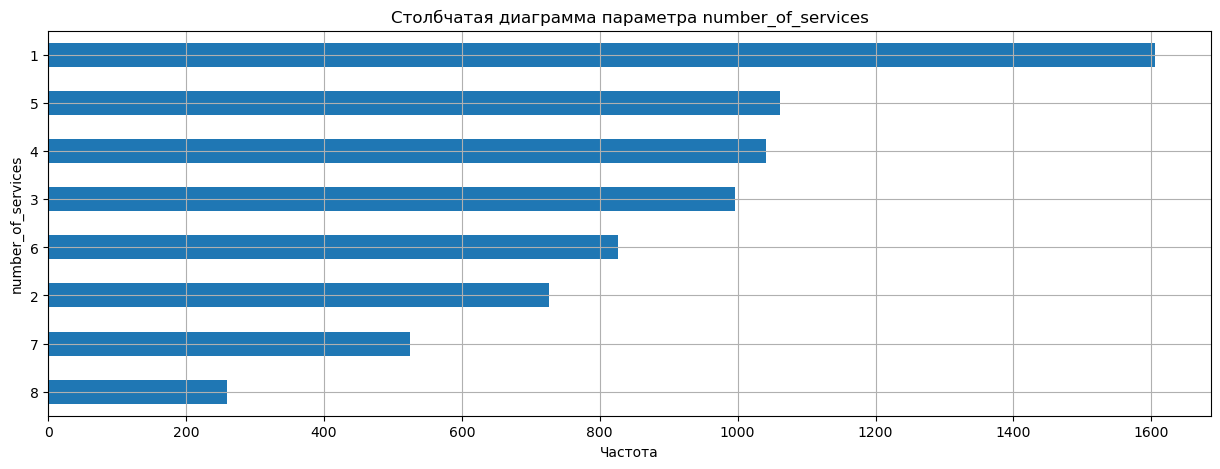

In [81]:
barh(df['number_of_services']) 

### "Портреты" пользователей

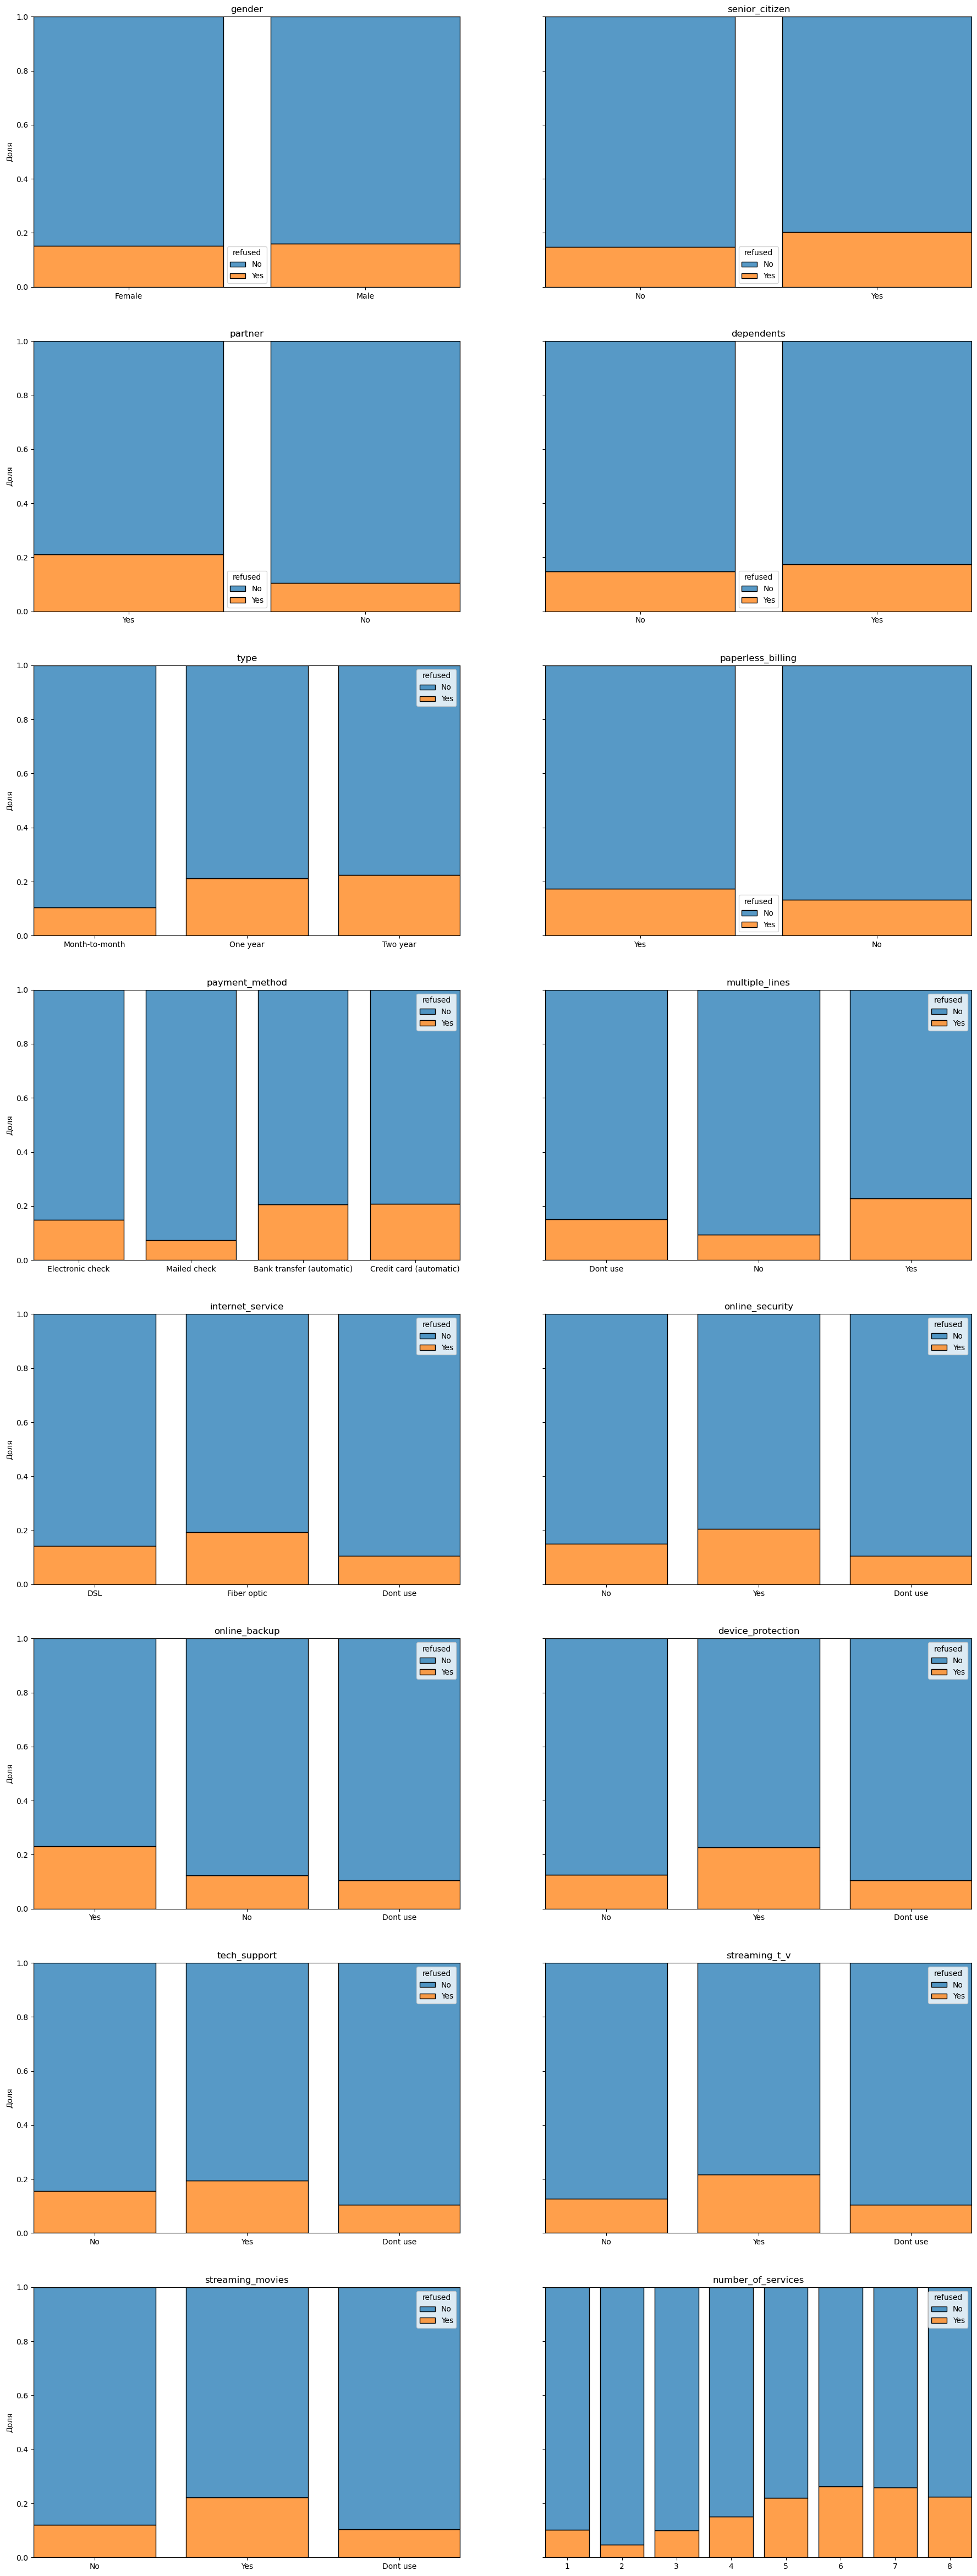

In [82]:
cols = ['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 
                         'payment_method', 'multiple_lines', 'internet_service',
                         'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v',
                         'streaming_movies', 'number_of_services']
fig, axs = plt.subplots(8, 2, figsize=(22,60), sharey=True)
for i, col in enumerate(cols):
    (sns.histplot(df, x=col, hue='refused', shrink=.8, multiple="fill", discrete=True, ax=axs[i//2,i%2])
    .set(title=col, ylabel = "Доля", xlabel=''))

Из полученных графиков можно сделать следующие выводы:
- доли оттока практически равны для обоих полов
- доля оттока среди пенсионеров немного выше
- доля оттока у пользователей с партнером выше
- доля оттока у пользователей с иждивенцами немного выше
- доля оттока у пользователей платящих раз в год или два выше, чем у платящих раз месяц, при этом между собой они примерно равны
- доля оттока у пользователей, выбирающих электронный чек, немного выше
- доля оттока у пользователей, выбирающих метод оплаты трансфер в банк или кредитную карту, немного выше, чем у выбирающих электронный чек и существенно выше, чем у выбирающих чек по почте. Также стоит отметить, что у двух методов с наиболее высокими долями автоматический способ оплаты
- касаемо интернет или телефонных услуг вывод можно обобщить: у пользователей, подключающих какую либо услугу доля оттока выше, чем у клиентов ее не подключающих и клиентов не подключающих данный вид связи (телефон или интернет)
- зависимость доли оттока от количества услуг нелинейная, наибольшая доля оттока у пользователей, подключающих 6-7 услуг

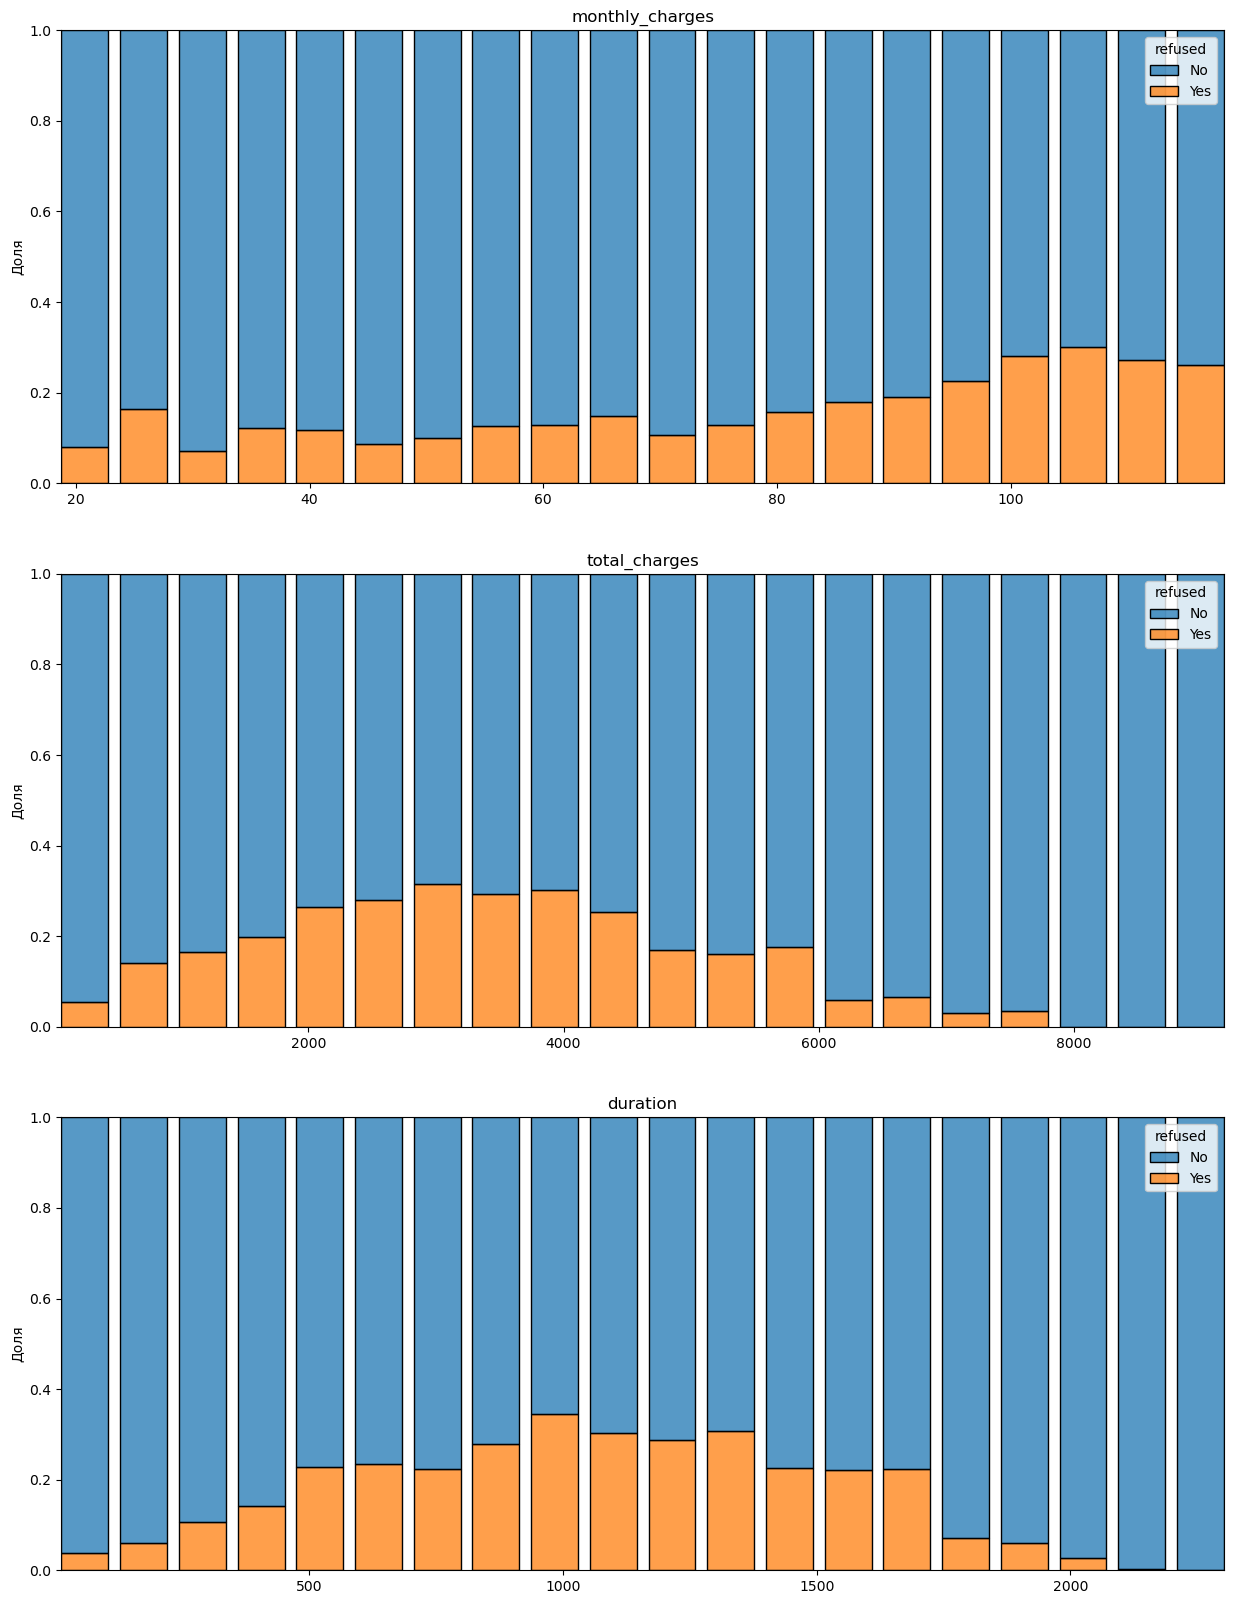

In [83]:
num_cols = ['monthly_charges', 'total_charges', 'duration']
fig, axs = plt.subplots(3, 1, figsize=(15,20), sharey=True)
for ax, col in zip(axs, num_cols):
    (sns.histplot(df, x=col, hue='refused', shrink=.8, multiple="fill", ax=ax, bins=20)
    .set(title=col, ylabel = "Доля", xlabel=''))

Из полученных графиков можно сделать следующие выводы:
- наибольшая доля оттока у пользователей с расходами за месяц в среднем 100 - 120, однако имеются всплески в промежутке от 20 до 60
- наибольшая доля оттока у пользователей с общими расходы 2000 - 4000
- наибольшая доля оттока у пользователей с длительностю пользования услугами 700 - 1300 дней

Отметим наиболее значимые выводы:
- доля оттока у пользователей с партнером выше
- доля оттока у пользователей платящих раз в год или два выше, чем у платящих раз месяц, при этом между собой они примерно равны
- доля оттока у пользователей, выбирающих метод оплаты трансфер в банк или кредитную карту, немного выше, чем у выбирающих электронный чек и существенно выше, чем у выбирающих чек по почте. Также стоит отметить, что у двух методов с наиболее высокими долями автоматический способ оплаты
- у пользователей, подключающих какую либо услугу доля оттока выше, чем у клиентов ее не подключающих и клиентов не подключающих данный вид связи (телефон или интернет)
- зависимость доли оттока от количества услуг нелинейная, наибольшая доля оттока у пользователей, подключающих 6-7 услуг
- наибольшая доля оттока у пользователей с расходами за месяц в среднем 100 - 120, однако имеются всплески в промежутке от 20 до 60
- наибольшая доля оттока у пользователей с общими расходы 2000 - 4000
- наибольшая доля оттока у пользователей с длительностю пользования услугами 700 - 1300 дней

### Корреляционный анализ данных

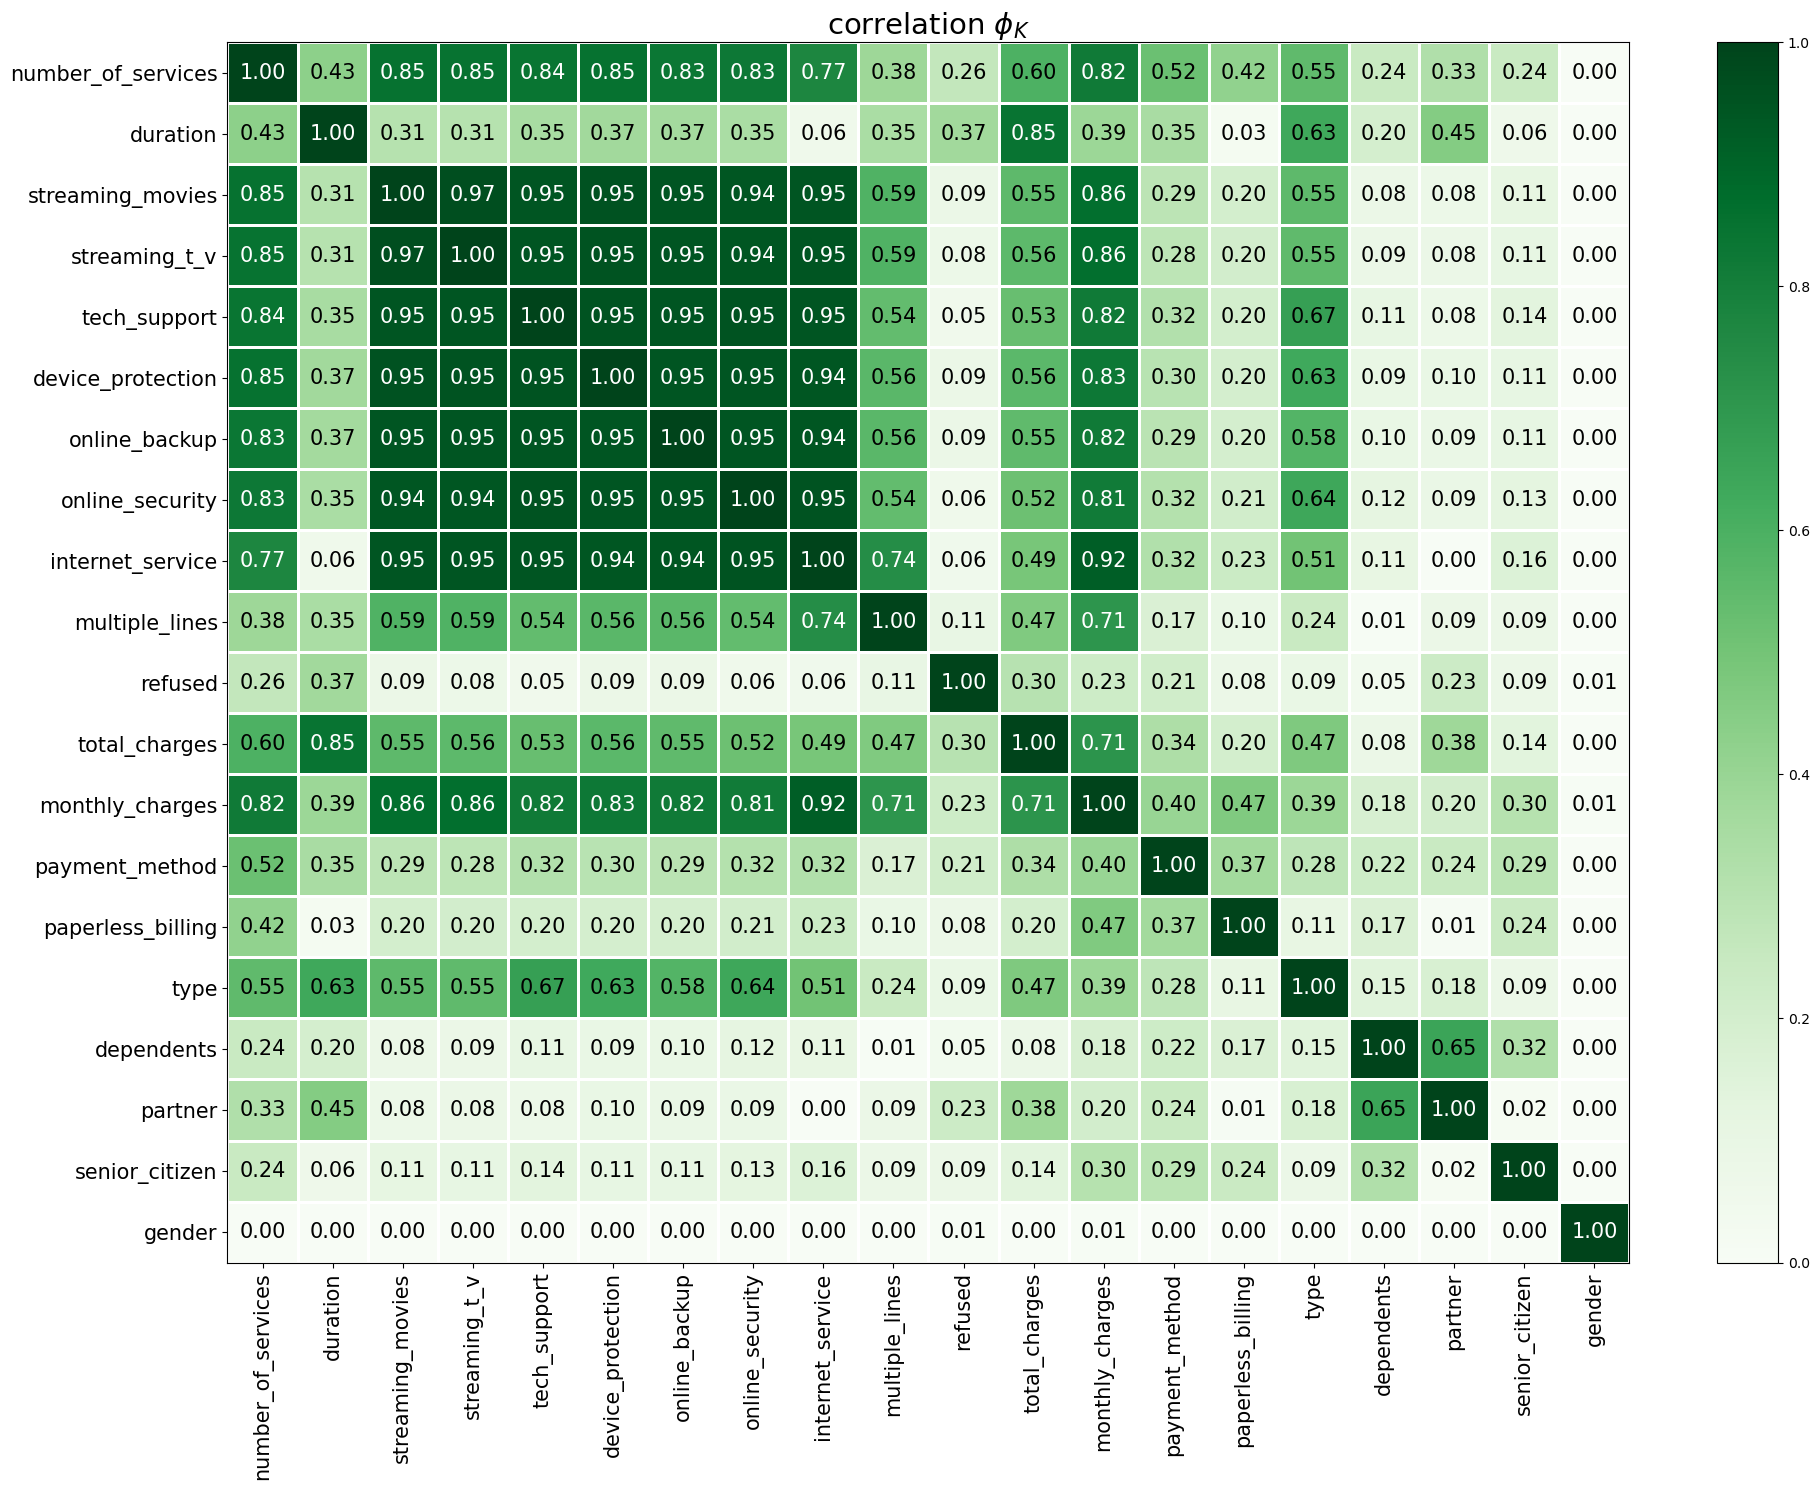

In [84]:
phik_overview = (df[['gender', 'senior_citizen', 'partner', 'dependents',
       'type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'refused', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'duration', 'number_of_services']]
.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration']))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видно, что имеется мультиколлинеарность, от нее стоит избавиться. Это признаки с услугами, у нас имеется столбец с суммой всех услуг, поэтому удалим эти признаки кроме одного. Признак gender также стоит удалить, так как не информативен и абсолютно не коррелирует с другими параметрами.

In [85]:
df_model = df.copy()
df_model = df_model.drop(['gender', 'internet_service', 'online_backup', 'device_protection', 
                          'tech_support', 'streaming_t_v', 'streaming_movies', 'customer_i_d'], axis=1)

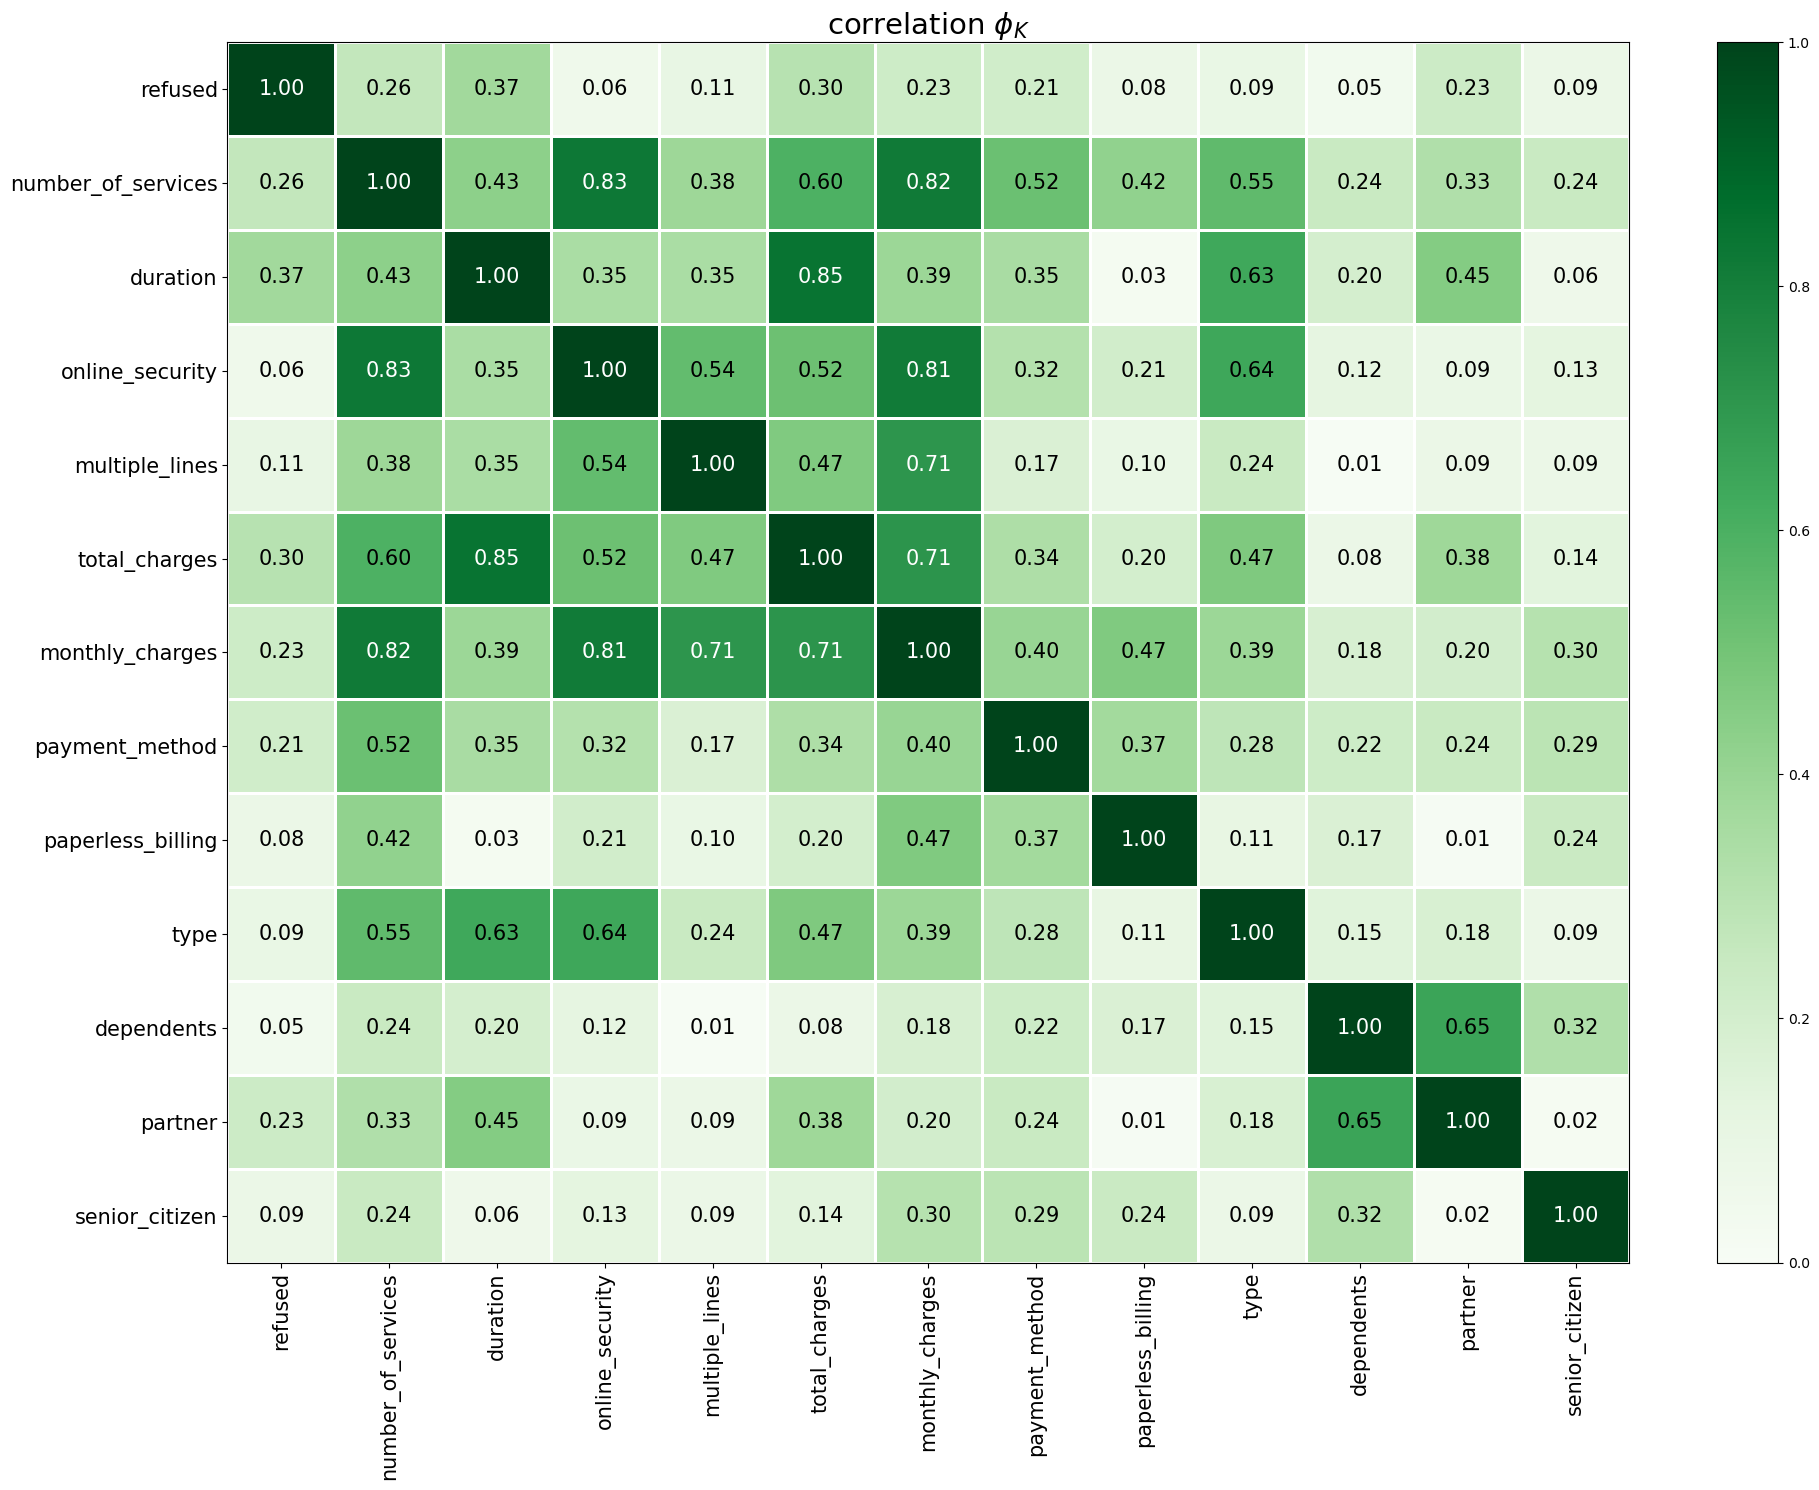

In [86]:
phik_overview = (df_model[['senior_citizen', 'partner', 'dependents',
       'type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'multiple_lines',
       'online_security', 'duration', 'number_of_services', 'refused']]
.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration']))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Наиболее высокая корреляция у таргета наблюдаеется с параметрами:
- number_of_services
- duration
- total_charges
- monthly_charges
- payment_method
- partner

## Подготовка данных

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop(['refused'], axis=1),
    df_model['refused'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_model['refused'])

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_test_le = label_encoder.transform(y_test)

ohe_columns = ['senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method']
ohe_service_columns = ['multiple_lines', 'online_security']
ord_columns = ['number_of_services']
num_columns = ['monthly_charges', 'total_charges', 'duration']

Разделим категориальные непорядковые признаки на две категории: признаки без услуг и с услугами. В первом случае пропуски будем заполнять стратегией most_frequent, так как в данной работе с пропусками в этих признаках мы не сталкивались и их природа нам неизвестна. Во втором случае природа пропусков нам известна, заполнять будем константой Dont use.

## Обучение моделей

### LogisticRegression

In [88]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)


ohe_service_pipe = Pipeline(
    [('simpleImputer_ohe_service', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Dont use')),
     ('ohe_service', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)


ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, 
                             categories=[[1, 2, 3, 4, 5, 6, 7, 8]])),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ohe_service', ohe_service_pipe, ohe_service_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ]
)


pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight = 'balanced'))
    ]
)


param_grid = [    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight = 'balanced')],
        'models__max_iter': range(1000, 2000, 100),
        'models__C': range(1, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]


gs_lr = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=8,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)


gs_lr.fit(X_train, y_train_le)

print('Лучшая модель и её параметры:\n\n', gs_lr.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс-валидации:', gs_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents', 'type',
                                                   'paperless_billing',
                                                   'payment_method']),
    

### DecisionTreeClassifier

In [89]:
ord_other_columns = ['senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method']
ord_other_service_columns = ['multiple_lines', 'online_security']
ord_columns = ['number_of_services']
num_columns = ['monthly_charges', 'total_charges', 'duration']

In [90]:
ord_other_pipe = Pipeline(
    [('simpleImputer_before_ord_other', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord_other',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord_other', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


ord_other_service_pipe = Pipeline(
    [('simpleImputer_before_ord_other_service', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Dont use')),
     ('ord_other_service',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord_other_service', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=[[1, 2, 3, 4, 5, 6, 7, 8]])),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ord_other', ord_other_pipe, ord_other_columns),
     ('ord_other_service', ord_other_service_pipe, ord_other_service_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ]
)


pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced'))
    ]
)


param_grid = [    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')],
        'models__max_depth': range(2, 150),
        'models__max_features': range(2, 150),
        'models__min_samples_split': range(2, 150),
        'models__min_samples_leaf': range(1, 150)
    }
]


rs_dtc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=8,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


rs_dtc.fit(X_train, y_train_le)

print('Лучшая модель и её параметры:\n\n', rs_dtc.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс-валидации:', rs_dtc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord_other',
                                                  Pipeline(steps=[('simpleImputer_before_ord_other',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_other',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord_other',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['senior_citizen', 'part...
                                                                        

### LGBMClassifier

In [91]:
warnings.filterwarnings(action="ignore")

ord_other_pipe = Pipeline(
    [('simpleImputer_before_ord_other', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord_other',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord_other', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


ord_other_service_pipe = Pipeline(
    [('simpleImputer_before_ord_other_service', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Dont use')),
     ('ord_other_service',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord_other_service', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=[[1, 2, 3, 4, 5, 6, 7, 8]])),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ord_other', ord_other_pipe, ord_other_columns),
     ('ord_other_service', ord_other_service_pipe, ord_other_service_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ]
)


pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
    ('models', LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ]
)


param_grid = [
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight = 'balanced')],
        'models__boosting_type': ['gbdt', 'dart'],
        'models__num_leaves': range(2, 100),
        'models__max_depth': range(2, 100)
    }
]


rs_lgbm = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=8,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs_lgbm.fit(X_train, y_train_le)

print('Лучшая модель и её параметры:\n\n', rs_lgbm.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс-валидации:', rs_lgbm.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord_other',
                                                  Pipeline(steps=[('simpleImputer_before_ord_other',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_other',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord_other',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['senior_citizen', 'part...
                                                                   Ordin

## Выбор лучшей модели

### Выбор 

In [92]:
print ('Метрика ROC-AUC модели LogisticRegression на кросс-валидации:', gs_lr.best_score_)
print ('Метрика ROC-AUC модели DecisionTreeClassifier на кросс-валидации:', rs_dtc.best_score_)
print ('Метрика ROC-AUC модели LGBMClassifier на кросс-валидации:', rs_lgbm.best_score_)

Метрика ROC-AUC модели LogisticRegression на кросс-валидации: 0.7569626313817086
Метрика ROC-AUC модели DecisionTreeClassifier на кросс-валидации: 0.7852105786158379
Метрика ROC-AUC модели LGBMClassifier на кросс-валидации: 0.8718021065319788


 Исходя из вышеприведенных данных лучшей моделью является LGBMClassifier со следующими гиперпараметрами:

In [93]:
print('Лучшая модель и её параметры:\n\n', rs_lgbm.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord_other',
                                                  Pipeline(steps=[('simpleImputer_before_ord_other',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_other',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord_other',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['senior_citizen', 'part...
                                                                   Ordin

### Тестирование и анализ модели

In [94]:
warnings.filterwarnings(action="ignore")

y_pred_proba = rs_lgbm.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_le, y_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.8898959990211672


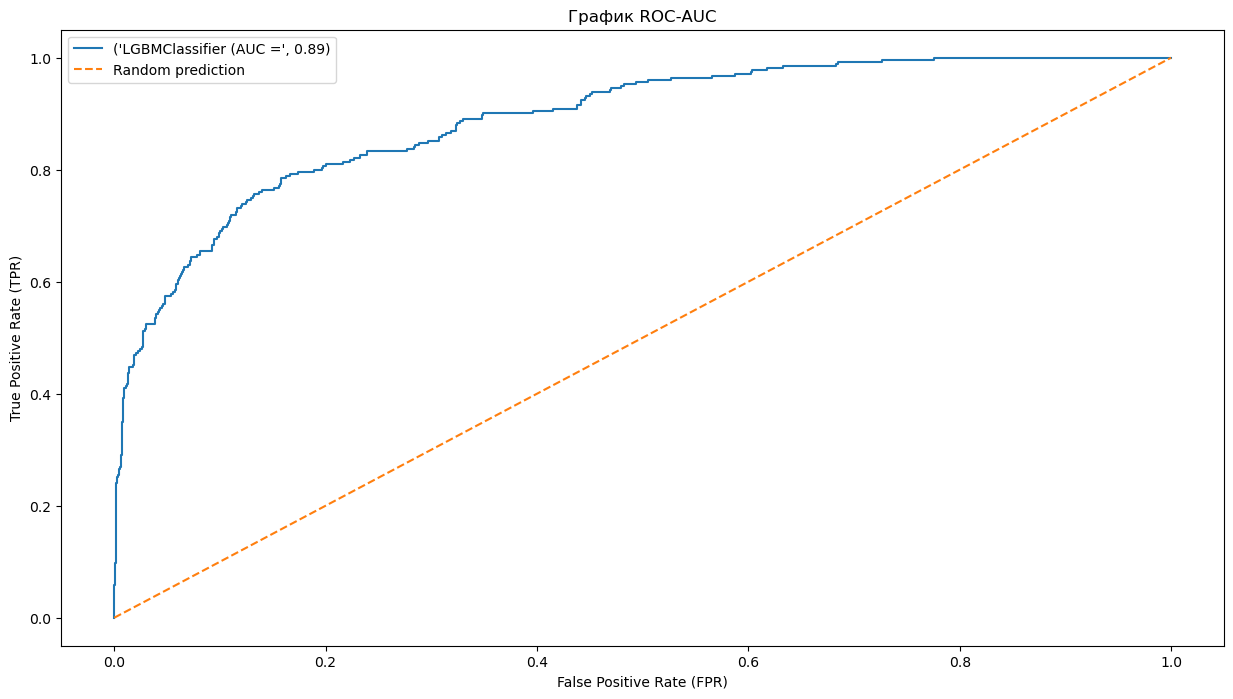

In [95]:
fpr, tpr, threshold = roc_curve(y_test_le, y_pred_proba)

fig = plt.subplots(figsize=(15,8), sharey=True)
plt.plot(fpr, tpr, label=('LGBMClassifier (AUC =', round(roc_auc_score(y_test_le, y_pred_proba), 2)))
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

Видно, что площадь под нашей кривой довольна близка к единице, что гораздо лучше случайной модели.

In [96]:
warnings.filterwarnings(action="ignore")

y_pred = rs_lgbm.predict(X_test)
print(f'Метрика accuracy на тестовой выборке: {accuracy_score(y_test_le, y_pred)}')

Метрика accuracy на тестовой выборке: 0.8784781374219194


Наша модель верно предсказывает класс в 0.88% случаев. Для получения более конкретных результатов обратимся к матрице ошибок.

Recall = 0.644 Precision = 0.604


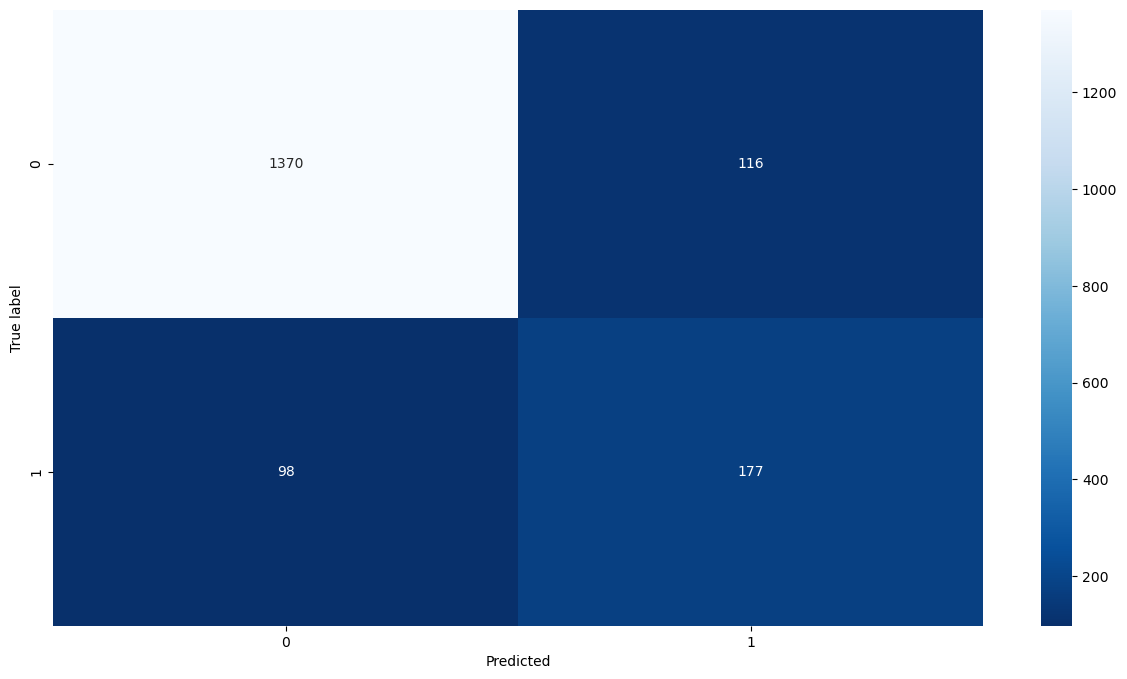

In [97]:
fig = plt.subplots(figsize=(15,8), sharey=True)
cm = confusion_matrix(y_test_le, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

recall = round(recall_score(y_test_le, y_pred), 3)
precision = round(precision_score(y_test_le, y_pred), 3)
print('Recall =', recall, 'Precision =', precision)

На данный момент метрики Recall и Precision составляют 0.764 и 0.409 соответственно. Неизвестно устранение какого рода ошибки в приоритете, соответственно оставляем все как есть. В дальнейшем у заказчика стоит уточнить этот момент, и можно будет настроить порог классификации.

  0%|          | 0/100 [00:00<?, ?it/s]

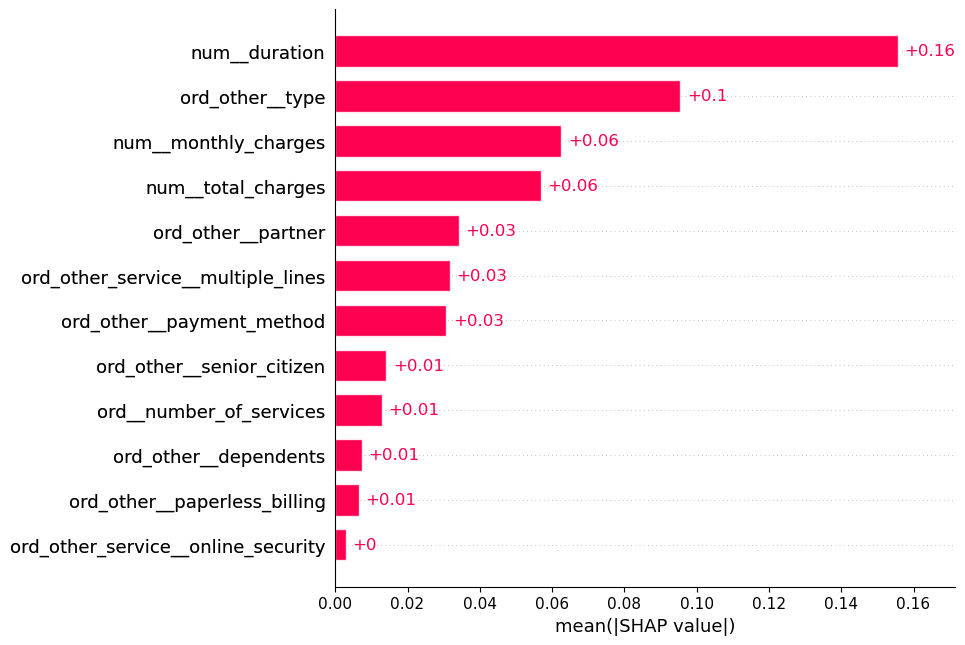

In [98]:
warnings.filterwarnings(action="ignore")

X = rs_lgbm.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = rs_lgbm.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.KernelExplainer(rs_lgbm.best_estimator_['models'].predict, shap.sample(X, 100))
shap_values = explainer(shap.sample(X, 100))

shap.plots.bar(shap_values, max_display=18)

Как видно из представленной картинки, синтетические параметры duration и number_of_services оказались достаточно важными.

## Вывод

В ходе данной работы были выполнены все входящие в план задачи:

1. Загрузка данных.


2. Исследовательский анализ данных и предобработка данных.

    1. Предобработка данных состояла из следующих пунктов:
        - изменение названий стобцов
        - изменение типов данных для параметров: begin_date и total_charges
        - преобразование столбца senior_citizen
        - создан таргет refused на основе признака end_date
        - неявные дубликаты отсутствуют
        - явные дубликаты отсутствуют
    2. На этапе исследовательского анализа данных были изучены распределения всех параметров. Помимо этого были заполнены пропуски в параметре total_charges на основе других параметров.


3. Объединение данных. Были объединены все четыре датафрейма. Помимо этого при объединении появились пропуски, которые были успешно заполнены.


4. Исследовательский анализ и предобработка данных объединённого датафрейма. 
    1. Были созданы два новых признака: duration и number_of_services
    2. Распределения были проанализированы в разрезе по целевой переменной после объединения таблиц, для определения "портретов" уходящего и остающегося клиентов. Ключевые моменты:
        - доля оттока у пользователей с партнером выше
        - доля оттока у пользователей платящих раз в год или два выше, чем у платящих раз месяц, при этом между собой они примерно равны
        - доля оттока у пользователей, выбирающих метод оплаты трансфер в банк или кредитную карту, немного выше, чем у выбирающих электронный чек и существенно выше, чем у выбирающих чек по почте. Также стоит отметить, что у двух методов с наиболее высокими долями автоматический способ оплаты
        - у пользователей, подключающих какую либо услугу доля оттока выше, чем у клиентов ее не подключающих и клиентов не подключающих данный вид связи (телефон или интернет)
        - зависимость доли оттока от количества услуг нелинейная, наибольшая доля оттока у пользователей, подключающих 6-7 услуг
        - наибольшая доля оттока у пользователей с расходами за месяц в среднем 100 - 120, однако имеются всплески в промежутке от 20 до 60
        - наибольшая доля оттока у пользователей с общими расходы 2000 - 4000
        - наибольшая доля оттока у пользователей с длительностю пользования услугами 700 - 1300 дней
    3. Был проведен корреляционный анализ данных
    4. Были отобраны признаки для обучения моделей. Для обучения модели использовались следующие признаки:
        - senior_citizen 
        - partner 
        - dependents 
        - type 
        - paperless_billing
        - payment_method 
        - monthly_charges 
        - total_charges 
        - refused
        - multiple_lines 
        - online_security 
        - duration
        - number_of_services
    
    
5. Подготовка данных. Данные были поделены на выборки, а также закодирован таргет.


6. Обучение моделей машинного обучения. Обучались следующие модели:
    1. LogisticRegression
    2. DecisionTreeClassifier
    3. LGBMClassifier
   
 По итогам обучения моделям удалось достичь следующих значений метрики ROC-AUC на кросс-валидации:
| Model    | ROC-AUC  |
|----------|----------|
| LogisticRegression    | 0,76 |
| DecisionTreeClassifier    | 0,79   |
| LGBMClassifier    | 0,87   |

 Также для данных моделей был осуществлен подбор оптимальных гиперпараметров, максимизирующих метрику ROC-AUC. Помимо этого для кодирования категориальных признаков использовались два кодировщика, для масштабирования был осуществлен подбор оптимального скейлера.


7. Выбор лучшей модели. Лучшей моделью стала модель градиентного бустинга LGBMClassifier со следующими гиперпараметрами:
    1. max_depth=14
    2. num_leaves=10
    
   Наиболее важными признаками стали:
    1. num_duration (duration)
    2. ohe_type_Two_year (основанный на признаке type)
    3. num_monthly_charges (monthly_charges)
    4. ohe_multiple_lines_No (основанный на признаке multiple_lines)
    5. ohe_partner_Yes (основанный на признаке partner)
    
    
Рекомендации заказчику:
1. учитывая разную стоимость ошибок первого и второго рода, а также бюджет на акции по удержанию клиентов, подобрать порог классификации
2. Добавить больше персональных данных о клиентах, например возраст, место жительства, заработная плата, работает ли и т.д.